# 1. Importing Depedendencies

Pada tahap ini dilakukan instalasi dan import dependencies yang dibutuhkan.

In [9]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d jauharmz/descripted-openbabel-mmff94-uff

! unzip "descripted-openbabel-mmff94-uff"

Dataset URL: https://www.kaggle.com/datasets/jauharmz/descripted-openbabel-mmff94-uff
License(s): unknown
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 109MB/s]
Archive:  descripted-openbabel-mmff94-uff.zip
  inflating: Descripted_OpenBabel_MMFF94_UFF.csv  


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
!pip install rdkit-pypi scikit-learn pandas
!pip install lightgbm

# !conda install -c conda-forge rdkit scikit-learn pandas
# !conda install -c conda-forge lightgbm

# !pip uninstall -y cffi
# !pip install --upgrade --force-reinstall cffi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 49.1 MB/s eta 0:00:00


In [12]:
import ast
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import time
import torch
import warnings

In [13]:
# from google.colab import drive
from lightgbm import LGBMRegressor
from matplotlib.colors import Normalize
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from xgboost import XGBRegressor

In [14]:
# Variabelized Functions\
# drive.mount('/content/drive')
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True
plt.style.use('ggplot')
tqdm.pandas()
warnings.filterwarnings('ignore')

# Predefined Variable
rs = 666

# 2. Data Loading

Pada tahap ini dilakukan loading dataset dengan judul [SMILES Enumeation Datasets](https://github.com/summer-cola/SMILES-enumeration-datasets/blob/master/logS/trainset.csv)

In [17]:
data_dir = '/content/Descripted_OpenBabel_MMFF94_UFF.csv' # '/kaggle/input/descripted-openbabel-mmff94-uff/Descripted_OpenBabel_MMFF94_UFF.csv'
data = pd.read_csv(data_dir)
data.loc[rs]

,666
Unnamed: 0,666
logS,-5.336148
molWt,435.86
numAtoms,30
molMR,107.6566
rings,4
aromatic,2
ap,0.4
chiralC,2
logP,2.5661


# 3. Data Understanding

Pada tahap ini dilakukan pemahaman fitur dataset serta fitur yang diekstrak.

## 3.1. Fitur Dataset

Pada tahap ini nama dan tipe data fitur dalam dataset diperhatikan.

In [18]:
ds = data.copy().drop(columns=['Unnamed: 0'])
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   logS                 7954 non-null   float64
 1   molWt                7954 non-null   float64
 2   numAtoms             7954 non-null   int64  
 3   molMR                7954 non-null   float64
 4   rings                7954 non-null   int64  
 5   aromatic             7954 non-null   int64  
 6   ap                   7954 non-null   float64
 7   chiralC              7954 non-null   int64  
 8   logP                 7954 non-null   float64
 9   hbd                  7954 non-null   int64  
 10  hba                  7954 non-null   int64  
 11  rb                   7954 non-null   int64  
 12  tpsa                 7954 non-null   float64
 13  nh2                  7954 non-null   int64  
 14  oh                   7954 non-null   int64  
 15  balabanJ             7954 non-null   f

In [19]:
def convert_string_to_list(string_list):
    return ast.literal_eval(string_list)

# Apply the conversion with a progress bar
tqdm.pandas(desc="Converting string to list")

# Assuming 'raw' is your DataFrame
ds['ecfp'] = ds['ecfp'].progress_apply(convert_string_to_list)

Converting string to list:   0%|          | 0/7954 [00:00<?, ?it/s]

### 3.1.1. Deskripsi Variabel Dataset

Berikut merupakan deskripsi masing-masing variabel beserta contoh nilai-nilainya.

| Variabel | Deskripsi | Nilai |
| - | - | - |
| Unnamed: 0 | Indeks otomatis yang dihasilkan saat data diimpor. | 0 |
| Compound ID | ID unik untuk mengidentifikasi setiap senyawa dalam dataset. | C4659 |
| InChIKey | Kode alfanumerik yang merupakan versi singkat dari InChI (International Chemical Identifier) untuk identifikasi molekul unik secara global. | WIKXJKUZYYOTBP-UHFFFAOYSA-N |
| SMILES  | Simplified molecular input line entry system, bentuk notasi untuk deskripsi struktur molekul menggunakan *short ASCII strings*. | CCCCC(COC(=O)N)(COC(=O)NC(C)C)C |
| logS | Nilai logaritmik dari kelarutan dalam air (S), yang mengindikasikan seberapa larut suatu senyawa dalam air. | -3.633501683 |
| logP | Nilai logaritmik dari koefisien partisi oktanol-air (P), yang menunjukkan lipofilisitas atau kecenderungan senyawa untuk larut dalam lemak atau air. | 3.504 |
| MW  | Massa molekul (Molecular Weight), yaitu total massa atom dari molekul dalam satuan dalton (Da). | 274.357 |
| smi | Representasi alternative SMILES | C C C C C ( C O C ( = O ) N ) ( C O C ( = O ) N C ( C ) C ) C |

`Dataset` yang digunakan terlihat memiliki data `eksperimen` sebagai variabel penentu `sifat` suatu molekul dalam `Cheminformatics`. Terutama `LogS` yang merepresentasikan `Bioavailability` suatu molekul terutama dalam bidang `Drug Discoveries`.



Dari variabel-variabel yang disediakan datset, variabel yang selanjutnya digunakan dalam proyek kali ini adalah `SMILES` dan `LogS`, sementara `LogP` dan `MW` `eksperimen` akan digantikan oleh variable `teoritis` yang sama hasil descriptor dari `SMILES` pada tahap `Ekstraksi Fitur`.

### 3.1.2. Visualisasi Sederhana molekul dari SMILES.

In [20]:
'''
# Select 2 shortest and 2 longest SMILES based on length
longest_smiles_data = ds.assign(smiles_length=ds['SMILES'].str.len())
shortest_smiles_data = longest_smiles_data.nsmallest(2, 'smiles_length')
longest_smiles_data = longest_smiles_data.nlargest(2, 'smiles_length')
combined_data = pd.concat([shortest_smiles_data, longest_smiles_data])[['Compound ID', 'SMILES']]

# Plot the molecules in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for j, (i, row) in enumerate(combined_data.iterrows()):
    smiles = row['SMILES']
    compound_id = row['Compound ID']

    molecule = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(molecule, size=(300, 300), options=opts)

    axes[j].imshow(img)
    # axes[j].set_title(f'{compound_id}', fontsize=10, y=1.0, pad=-20)  # Compound ID as title
    axes[j].set_xticks([])
    axes[j].set_yticks([])

plt.tight_layout()
plt.show()
'''

"\n# Select 2 shortest and 2 longest SMILES based on length\nlongest_smiles_data = ds.assign(smiles_length=ds['SMILES'].str.len())\nshortest_smiles_data = longest_smiles_data.nsmallest(2, 'smiles_length')\nlongest_smiles_data = longest_smiles_data.nlargest(2, 'smiles_length')\ncombined_data = pd.concat([shortest_smiles_data, longest_smiles_data])[['Compound ID', 'SMILES']]\n\n# Plot the molecules in a 2x2 grid\nfig, axes = plt.subplots(2, 2, figsize=(8, 8))\naxes = axes.flatten()\n\nfor j, (i, row) in enumerate(combined_data.iterrows()):\n    smiles = row['SMILES']\n    compound_id = row['Compound ID']\n\n    molecule = Chem.MolFromSmiles(smiles)\n    img = Draw.MolToImage(molecule, size=(300, 300), options=opts)\n\n    axes[j].imshow(img)\n    # axes[j].set_title(f'{compound_id}', fontsize=10, y=1.0, pad=-20)  # Compound ID as title\n    axes[j].set_xticks([])\n    axes[j].set_yticks([])\n\nplt.tight_layout()\nplt.show()\n"

Visualisasi 4 molekul contoh dari `smiles` yang memiliki jumlah `str` terpendek dan terpanjang pada dataset dan dibandingkan dengan data yang tertera pada database [PubChem](https://pubchem.ncbi.nlm.nih.gov/). Karena `smiles` memiliki sifat *simplicity* dan *brevity* sehingga secara eksplisit menidakan sebagian besar atom `Hidrogen` dan hanya merepresentasikan molekul dalam bentuk `2D`. Penambahan atom `Hidrogen` dan operasi `Molecular Embedding` serta `Optimasi Geometri` diperlukan sebelum melakukan `3D deskriptor`. Langkah ini penting untuk memastikan representasi struktur geometri `3D` yang akurat dan ideal.

## 3.2. Ekstraksi Fitur

### 3.2.1. Konversi smiles menjadi notasi untuk molekul 3D

In [21]:
# Install condacolab to enable conda in Google Colab
# !pip install -q condacolab
# import condacolab
# condacolab.install()

# Install Open Babel from conda-forge
# !conda install -c conda-forge openbabel -y

Pada tahap ini dilakukan generasi 3D molekul menggunakan optimasi `Mekanika Klasik`. Optimasi yang digunakan yaitu `MMFF94` (Merck molecular force field) dan `UFF` (Universal Force Field).`MMFF94` sangat `baik` dalam optmasi molekul organik sederhana namun memiliki range molekul yang `terbatas`, sehingga sebagai optimasi sekunder digunakan optimasi `UFF` yang berdara satu tingkat dibawah MMFF94 dan memiliki range molekul yang `luas`.

In [22]:
'''
# Initialize counters
mmff94_count = 0
uff_count = 0
none_count = 0

# Function to convert SMILES to a 3D molecule using Open Babel
def rep_3D_openbabel(smiles):
    global mmff94_count, uff_count, none_count  # Reference global counters

    try:
        # Create an RDKit molecule from SMILES
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)  # Add hydrogen atoms

        # Convert RDKit molecule to Open Babel molecule
        mol_block = Chem.MolToMolBlock(mol)
        ob_mol = pybel.readstring("mol", mol_block)

        # Ensure hydrogens are present and generate 3D coordinates
        ob_mol.addh()
        ob_mol.make3D()

        # Try MMFF94 optimization; if unsuccessful, fall back to UFF
        ff = pybel._forcefields["mmff94"]
        if ff.Setup(ob_mol.OBMol):
            mmff94_count += 1
        else:
            ff = pybel._forcefields["uff"]
            if ff.Setup(ob_mol.OBMol):
                uff_count += 1
            else:
                none_count += 1
                print(f"Failed to set up force field for SMILES: {smiles}")
                return None

        # Run initial optimization, perform conformer search, and further optimize
        ff.ConjugateGradients(100, 1.0e-3)
        ff.WeightedRotorSearch(100, 25)
        ff.ConjugateGradients(250, 1.0e-4)

        # Update coordinates after optimization
        ff.GetCoordinates(ob_mol.OBMol)

        # Write to temporary file and load back into RDKit
        ob_mol.write("mol", "temp.mol", overwrite=True)
        optimized_mol = Chem.MolFromMolFile("temp.mol", sanitize=True, removeHs=False)

        return optimized_mol if optimized_mol is not None else None
    except Exception as e:
        none_count += 1
        print(f"Failed to process SMILES: {smiles} - Error: {e}")
        return None  # Return None if any error occurs

# Applying the function to a DataFrame column
tqdm.pandas()
ds['SMILES3d'] = ds['SMILES'].progress_apply(rep_3D_openbabel)

# Display optimization results
print()
print(f"MMFF94 optimizations: {mmff94_count}")
print(f"UFF optimizations: {uff_count}")
print(f"Failed optimizations: {none_count}")
'''

'\n# Initialize counters\nmmff94_count = 0\nuff_count = 0\nnone_count = 0\n\n# Function to convert SMILES to a 3D molecule using Open Babel\ndef rep_3D_openbabel(smiles):\n    global mmff94_count, uff_count, none_count  # Reference global counters\n\n    try:\n        # Create an RDKit molecule from SMILES\n        mol = Chem.MolFromSmiles(smiles)\n        mol = Chem.AddHs(mol)  # Add hydrogen atoms\n\n        # Convert RDKit molecule to Open Babel molecule\n        mol_block = Chem.MolToMolBlock(mol)\n        ob_mol = pybel.readstring("mol", mol_block)\n\n        # Ensure hydrogens are present and generate 3D coordinates\n        ob_mol.addh()\n        ob_mol.make3D()\n\n        # Try MMFF94 optimization; if unsuccessful, fall back to UFF\n        ff = pybel._forcefields["mmff94"]\n        if ff.Setup(ob_mol.OBMol):\n            mmff94_count += 1\n        else:\n            ff = pybel._forcefields["uff"]\n            if ff.Setup(ob_mol.OBMol):\n                uff_count += 1\n        

Proses optimasi telah berhasil dilalkukan. Degan total yang berhasil dioptimasi sebanyak `6746/1208` (MMFF94/UFF) molekul dan `0` molekul gagal dioprimasi.

In [23]:
# ds3d = ds[ds['SMILES3d'].notna()]

Seluruh fitur yang **gagal** diekstrak menghasilkan nilai `None` dan dilakukan `notna()` sehingga data yang tersisa telah bersih dari `missing velue`.

In [24]:
# ds3d['SMILES3d'][rs]

Penambahan atom `Hidrogan` serta proses `Molecular Embedding` dan `Optimasi Geometri` **berhasil** dilakukan yang ditadai oleh adanya gugus `H` dan struktur dalam keadaan `3D`.

### 3.2.2. Ekstrakasi Fitur dari smiles Menggunakan Descriptor

Pada tahap ini dilakukan ekstraksi fitur menggunakan `Descriptor` tipe `OD`, `1D`, `2D`, dan `3D`.

In [25]:
def descriptors(mol: pd.DataFrame) -> pd.DataFrame:
    num_atoms = Descriptors.HeavyAtomCount(mol)
    num_carbons = len([atom for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6])
    num_non_carbons = num_atoms - num_carbons

    num_aromatic_atoms = len([atom for atom in mol.GetAtoms() if atom.GetIsAromatic()])
    aromatic_proportion = num_aromatic_atoms / num_atoms if num_atoms > 0 else 0

    non_carbon_proportion = num_non_carbons / num_atoms if num_atoms > 0 else 0

    descriptors = {
        # 0D
        'molWt': Descriptors.MolWt(mol),
        'numAtoms': num_atoms,
        'molMR' : Descriptors.MolMR(mol),
        # 1D
        'rings' : Descriptors.RingCount(mol),
        'aromatic' : Descriptors.NumAromaticRings(mol),
        'ap' : aromatic_proportion,
        'chiralC' : len(Chem.FindMolChiralCenters(mol, includeUnassigned=True)),
        'logP': Descriptors.MolLogP(mol),
        'hbd' : Descriptors.NumHDonors(mol),
        'hba' : Descriptors.NumHAcceptors(mol),
        'rb' : Descriptors.NumRotatableBonds(mol),
        'tpsa' : Descriptors.TPSA(mol),
        'nh2' : len(mol.GetSubstructMatches(Chem.MolFromSmarts("N"))),
        'oh': len(mol.GetSubstructMatches(Chem.MolFromSmarts("[OX2H]"))),
        # 2D
        'balabanJ' : Descriptors.BalabanJ(mol),
        'bertzCT' : Descriptors.BertzCT(mol),
        'hallKierAlpha' : Descriptors.HallKierAlpha(mol),
        'ipc' : Descriptors.Ipc(mol),
        'chi0' : Descriptors.Chi0(mol),
        'chi1' : Descriptors.Chi1(mol),
        'kappa1' : Descriptors.Kappa1(mol),
        'kappa2' : Descriptors.Kappa2(mol),
        'kappa3' : Descriptors.Kappa3(mol),
        'fractionCSP3' : Descriptors.FractionCSP3(mol),
        # 3D
        'asphericity': rdMolDescriptors.CalcAsphericity(mol),
        'eccentricity': rdMolDescriptors.CalcEccentricity(mol),
        'inertialShapeFactor': rdMolDescriptors.CalcInertialShapeFactor(mol),
        'radiusOfGyration': rdMolDescriptors.CalcRadiusOfGyration(mol),
        'spherocityIndex': rdMolDescriptors.CalcSpherocityIndex(mol),
          # Proportions
          'ncp' : non_carbon_proportion,
          # Fingerprint
          'ecfp': list(map(int, AllChem.GetMorganFingerprintAsBitVect(mol, radius=4, nBits=2048).ToBitString()))
    }
    return pd.Series(descriptors)

# descriptor_data = ds3d['SMILES3d'].progress_apply(descriptors)

Ekstraksi fitur menggunakan `Descriptor` tipe `OD`, `1D`, `2D`, dan `3D` **berhasil** dilakukan.
Berikut fitur-fitur beserta contoh masing-masing nilai-nya.

In [26]:
'''
df_desc = pd.concat([ds3d['logS'], descriptor_data], axis=1)
df_desc.loc[rs]
'''

"\ndf_desc = pd.concat([ds3d['logS'], descriptor_data], axis=1)\ndf_desc.loc[rs]\n"

Pada tahap ini keseluruhan fitur disimpan untuk kepentingan dokumentasi.

In [27]:
# df_desc.to_csv('Descripted.csv', index=True)

### 3.2.2. Deskripsi Fitur Utama

Berikut merupakan deskripsi masing-masing fitur beserta nilai-nilainya.


| Variabel | Deskripsi | Nilai |
| - | - | - |
| logS | LogS, nilai logaritmik kelarutan molekul (terutama obat) dalam air | -2.74 |
| molWt | Molecule weight, berat molekul | 170.92 |
| numAtoms | Jumlah atom berat (selain hidrogen dalam molekul). | 8 |
| molMR | Molecular refractivity, kemampuan molekul untuk membiaskan cahaya, terkait dengan polarizabilitas molekul. |  21.6 |
| rings | Jumlah cincin dalam struktur molekul | 0 |
| aromatic | Jumlah cincin dengan sifat aromatik dalam molekul. | 0 |
| ap | Aromatic proportion, rasio atom aromatik terhadap total atom. | 0.0 |
| chiralC | Jumlah pusat kiral (Karbon) dalam molekul. | 0 |
| logP | Koefisien partisi logaritmik mengukur kepolaran molekul. | 2.6496 |
| hbd | Jumlah donor ikatan hidrogen | 0 |
| hba | Jumlah akseptor ikatan hidrogen | 0 |
| rb | Rotatable bond, umlah ikatan rotasi| 1 |
| tpsa | Topological polar surface area, luas permukaan molekul yang bersifat polar | 0.0 |
| nh2 |  Jumlah gugus amina | 0 |
| oh | Jumlah gugus hidroksil | 0 |
| balabanJ | Indeks Balaban (Balaban J Index), ukuran kekompakan topologi molekul. | 4.020392 |
| bertzCT | Kompleksitas topologi Bertz (Bertz CT), ukuran kerumitan molekul berdasarkan struktur graf. | 67.01955 |
| hallKierAlpha |  Indeks Hall-Kier Alpha, terkait dengan bentuk molekul dan polarizabilitasnya. | 0.3 |
| ipc | Indeks polaritas informasi (Information Content Index), mengukur keragaman struktur molekul. |  21.306059 |
| chi1 | Chi Path Index 0, pengukuran topologi molekul berdasarkan jumlah dan jenis atom. | 7.0 |
| chi2 | Chi Path Index 1, pengukuran jalur molekul berdasarkan pola ikatan atom. |  3.25 |
| kappa1 | Indeks kappa molekuler 1, mengukur fleksibilitas molekul. | 8.3 |
| kappa2 | Indeks kappa molekuler 2, variasi lain untuk mengukur fleksibilitas molekul. |  1.91511 |
| kappa3 | Indeks kappa molekuler 3, variasi lebih lanjut dari pengukuran fleksibilitas.| 2.046098 |
|fractionCSP3 | Fraksi atom karbon dalam hibridisasi sp3 | 1.0|
| asphericity |  Asferisitas, pengukuran penyimpangan bentuk molekul dari bentuk bola sempurna. | 0.072556 |
| eccentricity | Eksentrisitas, pengukuran asimetri dalam distribusi atom molekul. | 0.785158 |
| inertialShapeFactor | Faktor bentuk inersia, yang menunjukkan bentuk molekul berdasarkan distribusi massa atom. | 0.003042 |
| radiusOfGyration | Jari-jari perputaran (Radius of Gyration), mengukur penyebaran atom dalam molekul relatif terhadap pusat massa. | 1.836359 |
| spherocityIndex | Indeks sferisitas, yang menunjukkan seberapa dekat bentuk molekul dengan bola. | 0.711911 |
| ncp | Proporsi non-karbon terhadap total atom dalam molekul. | 0.75 |
| ecfp | Extended Circular Fingerprints, representasi molekul berbasis bit. | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... ] |

Berikut gambaran representasi `struktur` suatu molekul menjadi `Fingerprint ECFP`.



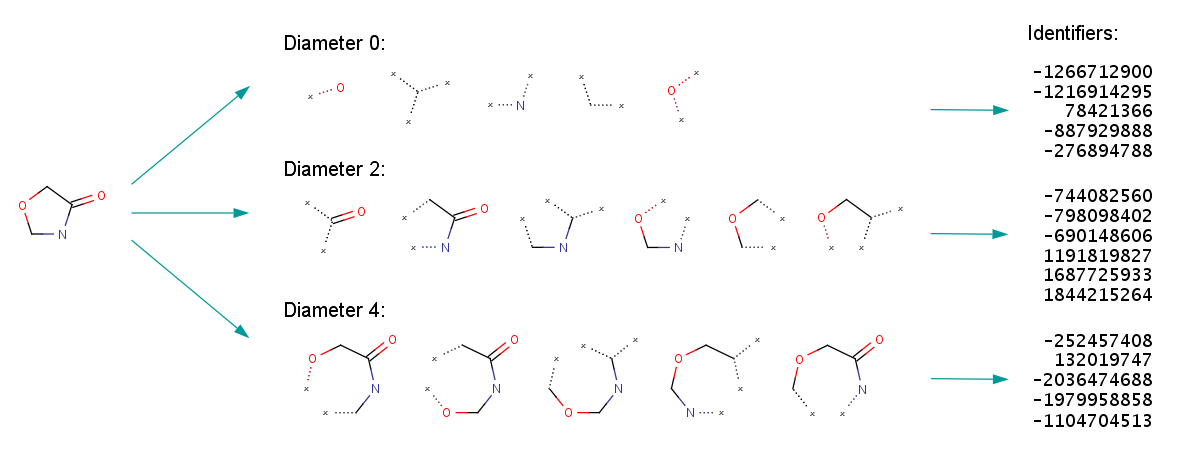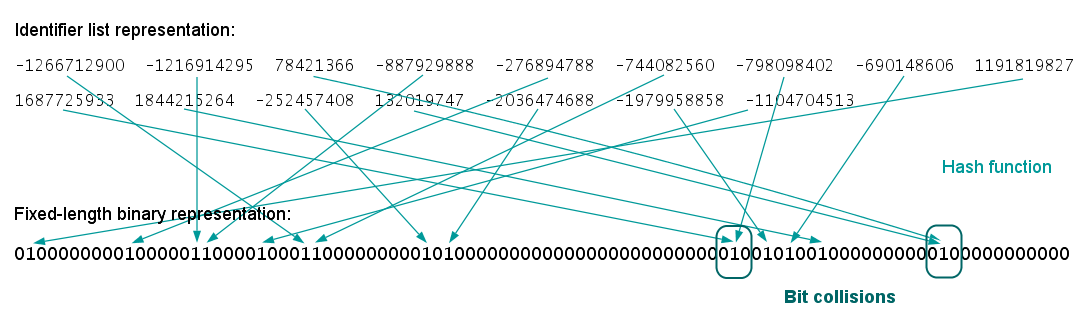

In [28]:
'''
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot 1: ECFP heatmap
ecfp_reshaped = np.array(df_desc['ecfp'][rs]).reshape((32, 64))
sns.heatmap(ecfp_reshaped, cbar=False, ax=axes[0])
axes[0].set_title(f'Bit ECFP of {ds3d["Compound ID"][rs]}')
axes[0].set_xlabel('Bit Position')
axes[0].set_ylabel('Bit Group')

# Plot 2: Molecule image
molecule = Chem.MolFromSmiles(ds3d["SMILES"][rs])
img = Draw.MolToImage(molecule, size=(300, 300), options=opts)

axes[1].imshow(img)
axes[1].set_title(f'{ds3d["Compound ID"][rs]}\n{ds3d["SMILES"][rs]}', pad=-30)
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()
'''

'\nfig, axes = plt.subplots(1, 2, figsize=(8, 4))\n\n# Plot 1: ECFP heatmap\necfp_reshaped = np.array(df_desc[\'ecfp\'][rs]).reshape((32, 64))\nsns.heatmap(ecfp_reshaped, cbar=False, ax=axes[0])\naxes[0].set_title(f\'Bit ECFP of {ds3d["Compound ID"][rs]}\')\naxes[0].set_xlabel(\'Bit Position\')\naxes[0].set_ylabel(\'Bit Group\')\n\n# Plot 2: Molecule image\nmolecule = Chem.MolFromSmiles(ds3d["SMILES"][rs])\nimg = Draw.MolToImage(molecule, size=(300, 300), options=opts)\n\naxes[1].imshow(img)\naxes[1].set_title(f\'{ds3d["Compound ID"][rs]}\n{ds3d["SMILES"][rs]}\', pad=-30)\naxes[1].set_xticks([])\naxes[1].set_yticks([])\n\nplt.show()\n'

Diatas merupakan visualisasi 2048 bit `Fingerprint ECFP` dari molekul contoh dalam matriks (32, 64).

### 3.2.3. Deskripsi Statistik

Pada tahap ini deskripsi statistik untuk masing-masing fitur.

In [29]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
logS,7954.0,-2.981528e+00,2.200720e+00,-1.625939e+01,-4.259388,-2.824600e+00,-1.489481e+00,1.580000e+00
molWt,7954.0,2.921520e+02,1.389096e+02,1.604300e+01,197.190000,2.737985e+02,3.597135e+02,1.583582e+03
numAtoms,7954.0,1.918180e+01,9.048712e+00,1.000000e+00,13.000000,1.800000e+01,2.300000e+01,1.090000e+02
molMR,7954.0,7.584078e+01,3.472421e+01,0.000000e+00,51.231650,7.204485e+01,9.398513e+01,3.702172e+02
rings,7954.0,1.975107e+00,1.461655e+00,0.000000e+00,1.000000,2.000000e+00,3.000000e+00,1.600000e+01
aromatic,7954.0,1.195248e+00,9.826727e-01,0.000000e+00,0.000000,1.000000e+00,2.000000e+00,1.200000e+01
ap,7954.0,3.520234e-01,2.609950e-01,0.000000e+00,0.000000,3.750000e-01,5.454545e-01,1.000000e+00
chiralC,7954.0,9.729696e-01,2.215340e+00,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,2.700000e+01
logP,7954.0,1.912550e+00,2.510816e+00,-4.666860e+01,0.779440,2.045950e+00,3.401700e+00,2.085460e+01
hbd,7954.0,1.239125e+00,1.513059e+00,0.000000e+00,0.000000,1.000000e+00,2.000000e+00,1.900000e+01


# 4. Data Cleaning

In [30]:
df = ds.copy()
df.columns

Index(['logS', 'molWt', 'numAtoms', 'molMR', 'rings', 'aromatic', 'ap',
       'chiralC', 'logP', 'hbd', 'hba', 'rb', 'tpsa', 'nh2', 'oh', 'balabanJ',
       'bertzCT', 'hallKierAlpha', 'ipc', 'chi0', 'chi1', 'kappa1', 'kappa2',
       'kappa3', 'fractionCSP3', 'asphericity', 'eccentricity',
       'inertialShapeFactor', 'radiusOfGyration', 'spherocityIndex', 'ncp',
       'ecfp'],
      dtype='object')

In [31]:
num_feature = df.select_dtypes('number').columns.tolist()
X_feature = num_feature[1:]
y_feature = ['logS']
ls_feature = ['ecfp']

Menyiapkan `variable` berdasarkan `dtype` pada fitur

## 4.1. Menangani Missing Value

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   logS                 7954 non-null   float64
 1   molWt                7954 non-null   float64
 2   numAtoms             7954 non-null   int64  
 3   molMR                7954 non-null   float64
 4   rings                7954 non-null   int64  
 5   aromatic             7954 non-null   int64  
 6   ap                   7954 non-null   float64
 7   chiralC              7954 non-null   int64  
 8   logP                 7954 non-null   float64
 9   hbd                  7954 non-null   int64  
 10  hba                  7954 non-null   int64  
 11  rb                   7954 non-null   int64  
 12  tpsa                 7954 non-null   float64
 13  nh2                  7954 non-null   int64  
 14  oh                   7954 non-null   int64  
 15  balabanJ             7954 non-null   f

Seluruh fitur **berhasil** diekstrak menggunakan `desciptor`. Sehingga tidak ditemukan `missing velue` dan penanganan `missing value` dapat diabaikan.

## 4.2. Memeriksa Outlier

Memeriksa fitur utama yang sama digunakan oleh model `ESOL` untuk menentukan `LogS` (target), seperti `logP`, `molWT`, `rb`, `ap`, `ncp`, `hbd`, `hba`, dan `tpsa` sebagai contoh.

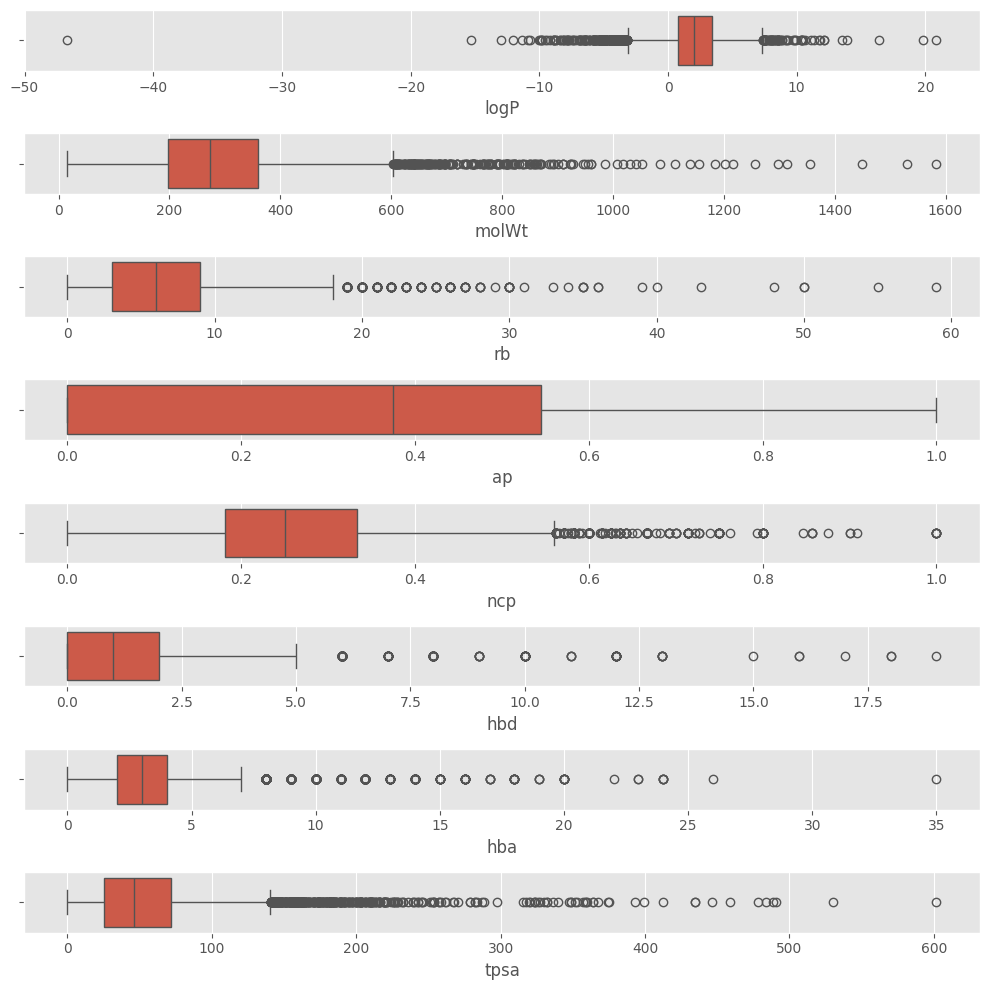

In [33]:
fig, axs = plt.subplots(8, 1, figsize=(10, 10))

sns.boxplot(x=df['logP'], ax=axs[0])
sns.boxplot(x=df['molWt'], ax=axs[1])
sns.boxplot(x=df['rb'], ax=axs[2])
sns.boxplot(x=df['ap'], ax=axs[3])
sns.boxplot(x=df['ncp'], ax=axs[4])
sns.boxplot(x=df['hbd'], ax=axs[5])
sns.boxplot(x=df['hba'], ax=axs[6])
sns.boxplot(x=df['tpsa'], ax=axs[7])

plt.tight_layout()
plt.show()

Beberapa sampel menunjukkan banyak `outlier` yang ekstem terhadap median, yang disebabkan oleh fitur yang diekstrak dari `struktur atom`, dengan variasi `jumlah` dan `jenis atom` pada molekul maka sagat mempengaruhi nilai yang diekstrak.

In [34]:
df['numAtoms'].describe()

,numAtoms
count,7954.000000
mean,19.181795
std,9.048712
min,1.000000
25%,13.000000
50%,18.000000
75%,23.000000
max,109.000000


Selain itu, `penurunan jumlah data` secara drastis, sebagai contoh dari `1144` sampel data hanya menyisakan `486` dan menyebabkan penanganan terhadap `outlier tidak dilakukan`.



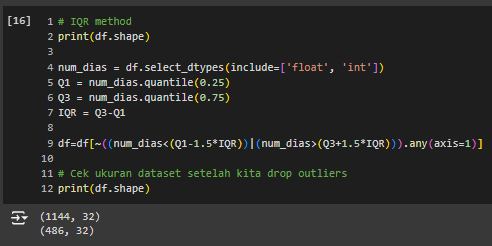

## 4.3. Memeriksa Data Duplikat

Data berbentuk List diubah menjadi Tuple agar fungsi `duplicated` dapat membaca data tersebut.

In [35]:
df['ecfp'] = df['ecfp'].apply(tuple)    # List -> Tuple

In [36]:
df.duplicated().sum()

1

Berdasarkan hasil di atas terdapat `1` data `duplikat` dalam dataset.

In [37]:
df[df.duplicated()]
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7953 entries, 0 to 7953
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   logS                 7953 non-null   float64
 1   molWt                7953 non-null   float64
 2   numAtoms             7953 non-null   int64  
 3   molMR                7953 non-null   float64
 4   rings                7953 non-null   int64  
 5   aromatic             7953 non-null   int64  
 6   ap                   7953 non-null   float64
 7   chiralC              7953 non-null   int64  
 8   logP                 7953 non-null   float64
 9   hbd                  7953 non-null   int64  
 10  hba                  7953 non-null   int64  
 11  rb                   7953 non-null   int64  
 12  tpsa                 7953 non-null   float64
 13  nh2                  7953 non-null   int64  
 14  oh                   7953 non-null   int64  
 15  balabanJ             7953 non-null   float6

# 5. EDA

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7953 entries, 0 to 7953
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   logS                 7953 non-null   float64
 1   molWt                7953 non-null   float64
 2   numAtoms             7953 non-null   int64  
 3   molMR                7953 non-null   float64
 4   rings                7953 non-null   int64  
 5   aromatic             7953 non-null   int64  
 6   ap                   7953 non-null   float64
 7   chiralC              7953 non-null   int64  
 8   logP                 7953 non-null   float64
 9   hbd                  7953 non-null   int64  
 10  hba                  7953 non-null   int64  
 11  rb                   7953 non-null   int64  
 12  tpsa                 7953 non-null   float64
 13  nh2                  7953 non-null   int64  
 14  oh                   7953 non-null   int64  
 15  balabanJ             7953 non-null   float6

Karena `tidak terdapat` fitur `kategorikal` dalam dataset, `EDA` hanya dilakukan pada fitur `numerik`.

## 5.1. Univariate - Numerical Features

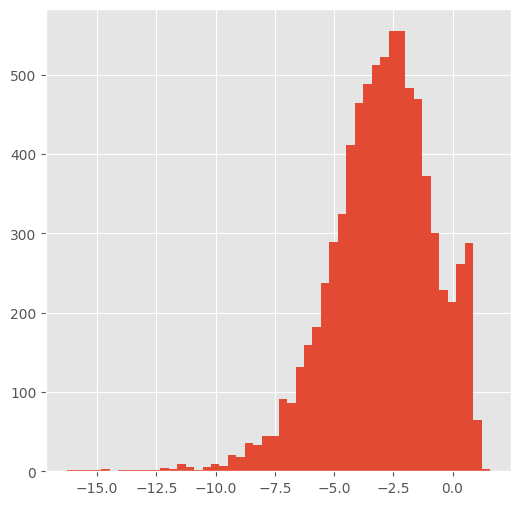

In [39]:
df['logS'].hist(bins=50, figsize=(6, 6))
plt.show()

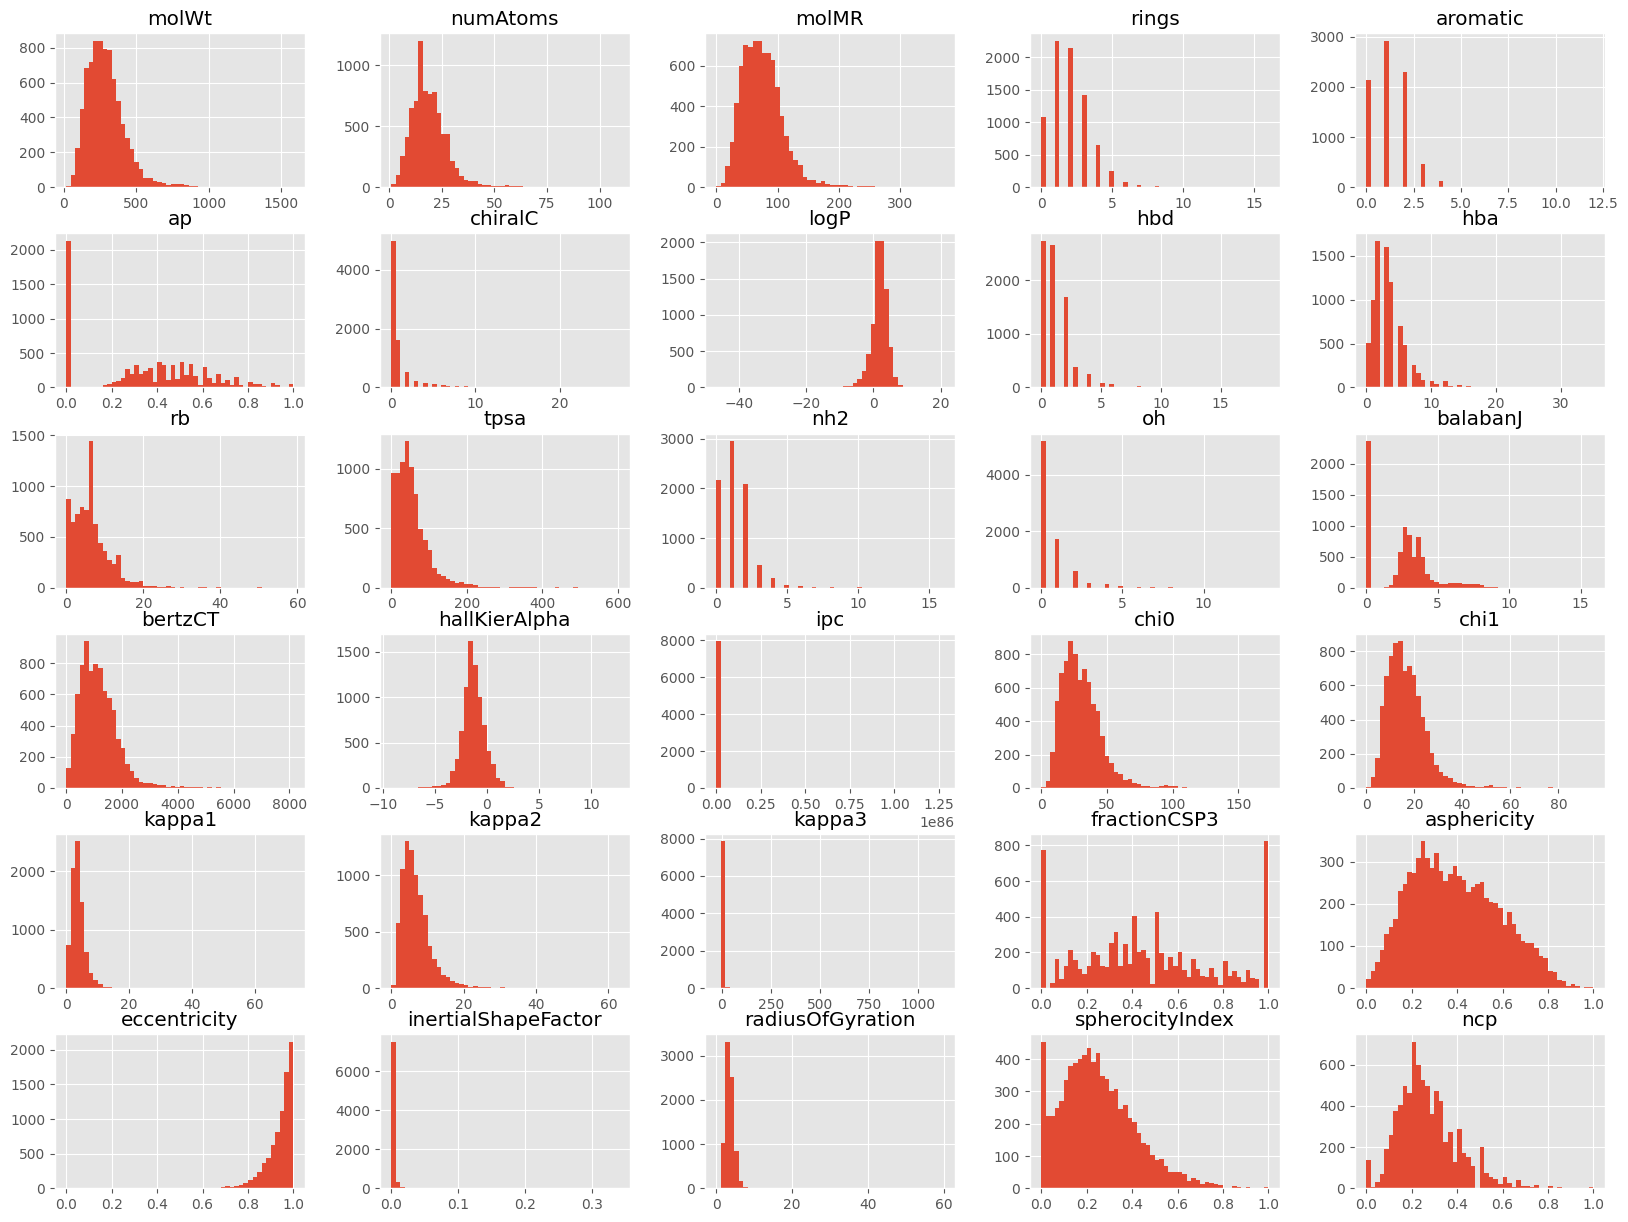

In [40]:
df[X_feature].hist(bins=50, figsize=(20, 15))
plt.show()

Pengamatan Umum:

* Skewness: Banyak fitur menunjukkan distribusi yang miring ke kanan, mengindikasikan ekor panjang ke arah nilai yang lebih tinggi.
* Outliers: Beberapa fitur seperti `molWt`, `numAtoms`, dan `molMR` memiliki potensi outlier, terlihat dari ekor panjang.
* Clustering: Fitur seperti `rings`, `hbd`, `hba`, `rb`, dan `chio` menunjukkan cluster yang berbeda, yang mengindikasikan kelompok tertentu dalam data.
* Distribusi Normal: Beberapa fitur seperti `ap` dan `tpsa` tampak mengikuti distribusi normal.

Pemahaman Fitur Spesifik:

* Sifat Molekuler: Fitur seperti `molWt`, `numAtoms`, dan `molMR` menunjukkan korelasi positif, mengindikasikan molekul yang lebih besar cenderung memiliki nilai yang lebih tinggi.
* Ikatan Hidrogen: `hbd` dan `hba` tampaknya memiliki korelasi negatif, menunjukkan bahwa molekul dengan lebih banyak donor ikatan hidrogen mungkin memiliki lebih sedikit akseptor.
* Struktur Cincin: `rings` dan `aromatic` merupakan fitur terkait, dikarenakan dengan cincin aromatik masuk kategori cincin namun tidak berlaku untuk sebaliknya.
* Deskripsi Bentuk: Fitur seperti `asphericity`, `eccentricity`, dan `spherocityIndex` memberikan wawasan tentang bentuk dan distribusi molekul.

## 5.2. Multivatiate - Numerical Features

In [41]:
# Mengamati hubungan antar fitur numerik dengan fungsi pairplot()
# sns.pairplot(df, diag_kind = 'kde')

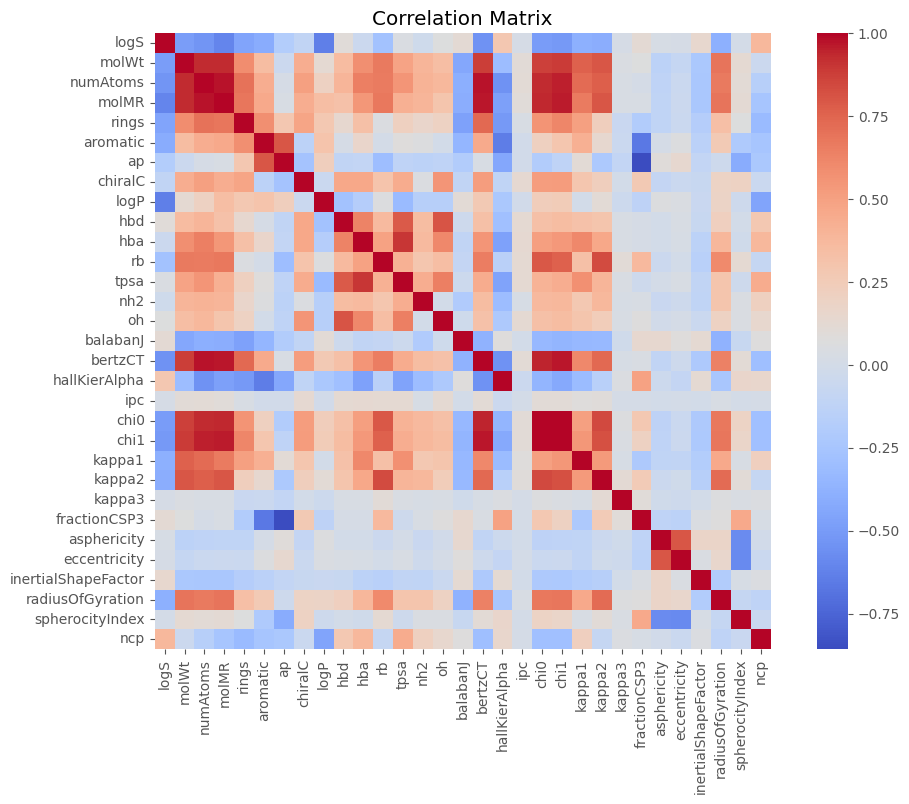

In [42]:
# Correlation matrix

correlation_matrix = df[num_feature].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap='coolwarm',
    square=True,
    cbar=True
    )

plt.title('Correlation Matrix')
plt.show()

Korelasi Positif `Kuat` dengan LogS:

* Molekul yang lebih besar (`berat molekul`, `jumlah atom`, dan `refraksi molar` yang lebih `tinggi`) cenderung memiliki `kelarutan` yang lebih `rendah`.
* Molekul yang lebih `kompleks` dengan `cincin` dan struktur `aromatik` cenderung memiliki `kelarutan` yang lebih `rendah` karena seringnya terjadi `resonansi` atau `stabilisasi PEB (Pasangan Elektron Bebas}`.

Korelasi Positif `Sedang` dengan LogS:

* Molekul yang lebih `lipofilik` (`logP` lebih `tinggi`) cenderung memiliki `kelarutan` yang lebih `rendah`.
* Molekul dengan `luas permukaan polar` yang lebih `besar` cenderung memiliki `kelarutan` yang lebih `rendah`.

Korelasi `Lemah` atau `Tidak Signifikan` dengan LogS:

* Banyak deskriptor molekuler lainnya memiliki korelasi `lemah` atau `tidak signifikan` dengan LogS. Ini menunjukkan bahwa fitur-fitur ini mungkin `tidak terlalu berpengaruh` dalam memprediksi kelarutan.

# 6. Data Preparation

## 6.1. Unpacks List Feature

Seperti yang telah dijelaskan sebelumnya, `Fingerprint ecfp` merupakan `representasi biner` dari struktur suatu molekul dengan jumlah `2048 bit` sehingga tidak dilakukan `encoding` dan hanya dilakukan *unpack* dari tipe `list` mejadi fitur sesuai jumlah bit-nya.

In [43]:
def unpack_ls(df: pd.DataFrame, column: str) -> pd.DataFrame:
    list_cols = pd.DataFrame(df[column].tolist(), index=df.index)
    list_cols.columns = [f'{column}{i+1}' for i in range(list_cols.shape[1])]

    return pd.concat([df.drop(columns=[column]), list_cols], axis=1)

In [44]:
df = unpack_ls(df, 'ecfp')
df.head()

,logS,molWt,numAtoms,molMR,rings,aromatic,ap,chiralC,logP,hbd,...,ecfp2039,ecfp2040,ecfp2041,ecfp2042,ecfp2043,ecfp2044,ecfp2045,ecfp2046,ecfp2047,ecfp2048
0,-3.633502,274.361,19,72.7871,0,0,0.000000,1,2.4128,2,...,0,0,0,0,0,0,0,0,0,0
1,-4.397670,292.318,21,89.9045,3,3,0.857143,0,4.2007,0,...,1,0,0,0,0,0,0,0,0,0
2,-4.760920,334.463,25,100.2470,4,2,0.480000,2,3.8612,0,...,1,0,0,0,0,0,0,0,0,0
3,-8.600000,360.882,18,81.9380,2,2,0.666667,0,7.2740,0,...,0,0,0,0,0,0,0,0,0,0
4,-4.086451,280.415,21,89.5860,3,2,0.571429,0,3.7874,0,...,1,0,0,0,0,0,0,0,0,0


Fitur `ecfp` telah berhasil dipecah menjadi 2048 fitur.

## 6.2. Reduksi Dimensi dengan PCA (Principal Component Analysis)

In [45]:
def extract_correlated_features(correlation_matrix, high_threshold=0.90):
    # Mask to ignore the diagonal and lower triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

    # Extract redundant (highly correlated) feature pairs
    high_corr_pairs = correlation_matrix.where(mask).stack().loc[lambda x: x > high_threshold]
    redundant_features = list(set([feature for pair in high_corr_pairs.index for feature in pair]))
    n_redundants = len(redundant_features)

    # Print results in tabular format using DataFrame
    redundant_df = pd.DataFrame(high_corr_pairs).reset_index()
    redundant_df.columns = ['Feature', 'Correlated with', 'Correlation']
    print("Redundant feature pairs (correlation > {:.2f}):".format(high_threshold))
    print(redundant_df.to_markdown(index=False))

    return redundant_features, n_redundants

# Example usage
# redundant_features, n_redundants = extract_correlated_features(correlation_matrix)

Berdasarkan data `correlation matrix` terdapat beberapa fitur yang memiliki korelasi >0.90 dan berikut merupakan plot korelasi antar fitur.

In [46]:
# sns.pairplot(df[redundant_features], plot_kws={"s": 3});

In [47]:
'''
pca = PCA(n_components=n_redundants, random_state=rs)
pca.fit(df[redundant_features])
pca.explained_variance_ratio_.round(3)
'''

'\npca = PCA(n_components=n_redundants, random_state=rs)\npca.fit(df[redundant_features])\npca.explained_variance_ratio_.round(3)\n'

`PC#1` menyimpan `Keseluruhan` informasi dari fitur yang saling berkorelasi.

In [48]:
'''
pca = PCA(n_components=1, random_state=rs)
pca.fit(df[redundant_features])
df['reduced'] = pca.transform(df[redundant_features]).flatten()
df.drop(redundant_features, axis=1, inplace=True

df.head()
'''

"\npca = PCA(n_components=1, random_state=rs)\npca.fit(df[redundant_features])\ndf['reduced'] = pca.transform(df[redundant_features]).flatten()\ndf.drop(redundant_features, axis=1, inplace=True\n\ndf.head()\n"

Dikarenakan projek kali ini berfokus pada `fitur` yang `berpengaruh` terhadap `prediksi model`, maka fitur-fitur yang saling `berkorelasi` `tidak direduksi` untuk mempertahankan `bobot` atau `infromasi` di setiap fitur.

## 6.3. Train-Test-Split

Inisiasi variabel data `Input` dan `Label`.

In [49]:
X = df.drop(columns=['logS'], axis=1)
y = df['logS']

Splitting data dan memastikan `bentuk` variabel `Input` dan `Label` data `Train` dan `Test`.

In [50]:
# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs)

# Display shapes of the training and test sets
print("[Train]")
print("Data (total, fitur):", X_train.shape)
print("Label (total, fitur)", y_train.shape)
print("[Test]")
print("Data (total, fitur):", X_test.shape)
print("Label (total, fitur)", y_test.shape)

[Train]
Data (total, fitur): (7157, 2078)
Label (total, fitur) (7157,)
[Test]
Data (total, fitur): (796, 2078)
Label (total, fitur) (796,)


## 6.4. Standarisasi pada fitur dengan dtype float.

| **Scaler**               | **Deskripsi**                                                                                                   | **Rumus**                                                                                    | **Efek pada Data**                              |
|--------------------------|------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|-------------------------------------------------|
| **StandardScaler**       | Skala data agar memiliki mean 0 dan standar deviasi 1. Berguna ketika data mengikuti distribusi normal.         | z = (x - mean(x)) / std(x)                                                                   | Menyelaraskan data (mean = 0) dengan variansi 1 (std = 1).           |
| **MinMaxScaler**         | Mengubah skala data ke rentang tertentu (default 0 hingga 1). Berguna untuk transformasi dalam batas tertentu.   | z = (x - min(x)) / (max(x) - min(x))                                                         | Menggeser dan menskalakan data agar sesuai dalam rentang tertentu, biasanya [0, 1]. |
| **RobustScaler**         | Menggunakan median dan interquartile range (IQR) untuk mengurangi pengaruh outlier dalam skala data.            | z = (x - median(x)) / IQR(x)                                                                 | Menyelaraskan data menggunakan median dan menskalakan berdasarkan IQR, mengurangi dampak outlier. |
| **QuantileTransformerN** | Mengubah data agar mengikuti distribusi normal. Menerapkan transformasi peringkat, berguna untuk data non-Gaussian. | Memetakan kuantil data ke distribusi normal standar.                                          | Membuat distribusi data menjadi normal, menggeser mean dan standar deviasi. |
| **QuantileTransformerU** | Mengubah data agar mengikuti distribusi uniform. Berguna untuk membuat distribusi lebih seragam.                | Memetakan kuantil data ke distribusi uniform (sering dalam [0, 1]).                           | Mengubah data menjadi sebaran seragam, tanpa terpusat pada mean. |
| **PowerTransformer**     | Menerapkan transformasi daya (Box-Cox atau Yeo-Johnson) untuk menstabilkan variansi dan membuat data lebih mendekati distribusi Gaussian. | z = (x^λ - 1) / λ (Box-Cox); x = log(x) untuk Yeo-Johnson | Menggeser dan menskalakan data, sering kali mengurangi skewness untuk mendekati distribusi Gaussian. |

Pada tahap ini dilakukan evaluasi performa *scaler* pada data `flaot64`.

In [51]:
# Re-define float_features based on X_train to avoid index issues
float_features = X_train.select_dtypes(include=['float64']).columns.intersection(X_train.columns)

# List of scalers to try, including PowerTransformer
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'QuantileTransformerN': QuantileTransformer(output_distribution='normal'),
    'QuantileTransformerU': QuantileTransformer(output_distribution='uniform'),
    'PowerTransformer': PowerTransformer()
}

# Dictionary to store results
scaler_scores = {}

# Loop through each scaler and evaluate performance
for scaler_name, scaler in scalers.items():
    # Fit the scaler on the training data float features
    scaled_data = scaler.fit_transform(X_train[float_features])

    # Use a simple model for evaluation (e.g., linear regression)
    model = LinearRegression()
    scores = cross_val_score(model, scaled_data, y_train, cv=5, scoring='neg_mean_squared_error')

    # Store the mean score for each scaler
    scaler_scores[scaler_name] = np.mean(scores)

# Display the results
best_scaler_name = max(scaler_scores, key=scaler_scores.get)
print(f"Best scaler: {best_scaler_name} with score: {scaler_scores[best_scaler_name]}")

Best scaler: QuantileTransformerN with score: -1.4793369599164947


### 6.4.1 Data Train

*Scaler* terbaik disimpan dan diaplikasikan pada data `Train` dan `Test`.

In [52]:
best_scaler = scalers[best_scaler_name]
best_scaler.fit(X_train[float_features])
X_train[float_features] = best_scaler.transform(X_train.loc[:, float_features])
X_train[float_features].head()

,molWt,molMR,ap,logP,tpsa,balabanJ,bertzCT,hallKierAlpha,ipc,chi0,...,kappa1,kappa2,kappa3,fractionCSP3,asphericity,eccentricity,inertialShapeFactor,radiusOfGyration,spherocityIndex,ncp
508,0.761417,0.802345,0.165095,0.435801,0.971436,-0.097936,0.819853,-0.008782,0.594759,0.555462,...,0.800970,0.941700,1.047252,0.031369,1.545152,1.545885,-0.053652,1.333420,-0.738138,0.621099
1718,-0.830263,-0.616717,0.357496,-0.683813,0.196979,0.804785,-0.554986,0.295296,-0.456874,-0.433482,...,-1.006211,-0.399053,0.015499,-0.110627,1.445607,1.448002,1.212427,-0.237231,-0.874201,-0.157469
1963,1.434467,1.258506,-5.199338,0.144188,1.503437,-0.223195,1.419789,-1.579968,1.499179,1.505483,...,1.322915,0.929771,0.838957,0.691121,-1.150019,-1.027922,-1.294075,0.756788,1.148411,0.346817
7266,-0.940429,-0.755977,0.724973,-0.172693,-1.215372,-1.467456,-0.772776,0.788455,-0.804272,-0.791884,...,-1.073841,-0.819702,-0.961512,-0.362850,-0.516248,-0.454729,0.826629,-1.192418,-0.630476,-0.651824
3785,-0.922933,-1.032563,-5.199338,-0.552042,0.278302,1.053309,-0.924758,0.295296,-0.742127,-0.611010,...,-1.052917,-1.066259,-1.385414,0.853480,-1.491941,-1.417163,0.727216,-1.242972,1.548944,0.621099


In [53]:
X_train[float_features].describe().round(4)

,molWt,molMR,ap,logP,tpsa,balabanJ,bertzCT,hallKierAlpha,ipc,chi0,...,kappa1,kappa2,kappa3,fractionCSP3,asphericity,eccentricity,inertialShapeFactor,radiusOfGyration,spherocityIndex,ncp
count,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,...,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000,7157.0000
mean,0.0000,0.0000,-1.0508,0.0001,-0.1798,0.0003,-0.0002,-0.0004,-0.0005,-0.0001,...,-0.0001,-0.0005,0.0003,0.0175,-0.0008,-0.0002,-0.0004,-0.0002,-0.0073,-0.0452
std,1.0020,1.0018,2.6046,1.0016,1.5030,1.0010,1.0033,1.0023,1.0011,1.0025,...,1.0016,1.0035,1.0024,2.3954,1.0058,1.0045,1.0051,1.0028,1.0329,1.1672
min,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,...,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993,-5.1993
25%,-0.6743,-0.6748,-5.1993,-0.6738,-0.6737,-0.6750,-0.6748,-0.6769,-0.6749,-0.6737,...,-0.6763,-0.6744,-0.6751,-0.6784,-0.6741,-0.6749,-0.6740,-0.6740,-0.6751,-0.6518
50%,-0.0009,0.0006,-0.0125,-0.0003,-0.0013,0.0001,-0.0005,-0.0088,0.0005,-0.0000,...,0.0010,0.0002,-0.0008,-0.0038,-0.0008,-0.0006,0.0004,-0.0005,0.0002,0.0100
75%,0.6737,0.6742,0.7250,0.6745,0.6743,0.6751,0.6744,0.6737,0.6741,0.6743,...,0.6751,0.6747,0.6756,0.6911,0.6742,0.6742,0.6752,0.6747,0.6746,0.6211
max,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,...,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993,5.1993


Fitur dengan dtype `float` telah berhasil dilakukan `QuantileTransformer Normal` dengan membatasi nilai `min` dan `max` menjadi `-5.1993` dan `5.1993` dan mengakibatkan pergeseran nilai `mean` dan `std`.

### 6.4.2. Data Test

In [54]:
# X_Test
X_test.loc[:, float_features] = best_scaler.transform(X_test[float_features])

`Standardisasi` juga diaplikasikan pada `data test`

# 7. Modeling

Pengujian model prediksi nilai `LogS` menggunakan beberapa model `regressor` seperti `NeuralNetwork`, `KNN`, `RandomForest`, `SVR`, `ElasticNet`, `DecisionTree`, `XGBoost`, `ExtraTrees`, dan `LGBM`.

| Model               | Penanganan Fitur       | Risiko Overfitting | Cocok untuk Dimensi Tinggi?  | Kemungkinan Performanya Baik |
|---------------------|------------------------|---------------------|------------------------------|------------------------------|
| **Neural Network**  | Baik dengan fitur banyak, perlu penyesuaian hati-hati | Sedang-Tinggi      | Ya, jika diatur regulerisasinya | **Sedang**: Potensi tinggi, tetapi berisiko overfitting dengan data terbatas |
| **K-Nearest Neighbors** (KNN) | Kesulitan dengan dimensi tinggi | Rendah | Tidak | **Rendah**: Kemungkinan underperform karena masalah dimensi tinggi |
| **Random Forest** (RF) | Menangani banyak fitur dengan baik | Rendah (karena rata-rata ensemble) | Ya | **Tinggi**: Efektif dengan data berdimensi tinggi dan fitur biner |
| **Support Vector Regression** (SVR) | Efektif di dimensi tinggi, perlu penyesuaian | Sedang | Ya, tetapi sensitif terhadap kernel | **Sedang**: Dapat bagus, tetapi butuh penyesuaian parameter |
| **ElasticNet** (EN) | Cocok untuk data sparsi dan berdimensi tinggi | Sedang | Ya | **Sedang**: Membutuhkan tuning; bagus jika terdapat sparsitas |
| **Decision Tree** (DT) | Sederhana tetapi mudah overfit | Tinggi | Tidak | **Sedang-Rendah**: Mungkin kesulitan dengan dataset kecil dan overfitting |
| **XGBoost** (XGB) | Sangat baik untuk data berdimensi tinggi | Rendah | Ya | **Tinggi**: Kandidat kuat karena ketangguhan dan seleksi fitur |
| **Extra Trees** (ET) | Mirip RF tetapi kurang rentan terhadap noise | Rendah | Ya | **Tinggi**: Andal dan efisien untuk tipe data ini |
| **LightGBM** (LGBM) | Sangat baik untuk fitur biner/kategori berdimensi tinggi | Rendah | Ya | **Tinggi**: Kandidat kuat, efisien untuk fitur biner |

### Sifat Model:
1. **Kontrol Overfitting**: Model ensemble seperti `RandomForest`, `ExtraTrees`, `XGBoost`, dan `LightGBM` memiliki metode bawaan untuk mencegah overfitting, sehingga cocok untuk dataset kecil dengan dimensi tinggi.
2. **Penanganan Fitur Biner**: Model seperti `LightGBM` dan `XGBoost` sangat efisien dengan fitur sparsi atau biner, seperti fingerprint `ECFP`.
3. **Sensitivitas Dimensi**: `KNN` dan `Decision Trees` sering mengalami kesulitan dengan dimensi tinggi, sehingga kemungkinan performanya kurang baik pada dataset ini.

### Hipotesis:
- **Pilihan Terbaik**: `RandomForest`, `ExtraTrees`, `XGBoost`, dan `LightGBM` karena ketahanan dan kemampuannya untuk menggeneralisasi dengan baik pada dataset kecil.
- **Underperform**: `KNN` dan `Decision Trees` untuk data berdimensi tinggi ini, kecuali jika direduksi melalui teknik seperti PCA.

`Hyperparameter Tuning` masing-masing model telah dilakukan sebelumnya dengan hasil sebagai berikut:

| Model          | Parameter            | Range/Choices                    | Optimal Value                     |
|----------------|----------------------|----------------------------------|-----------------------------------|
| **NeuralNetR** | epochs               | 34 - 35                          | 34                                |
|                | patience             | 5 - 6                            | 5                                 |
|                | batch_size           | 89 - 90                          | 89                                |
|                | lr                   | 9e-4 - 2e-3                      | 0.0023                            |
|                | weight_decay         | 5e-5 - 6e-5                      | 0.0001                            |
| | | | |
| **KNN**        | n_neighbors          | 5 - 6                            | 5                                 |
|                | p                    | 1 - 2                            | 1                                 |
|                | weights              | ['uniform', 'distance']          | distance                          |
| | | | |
| **RandomForest** | n_estimators       | 95 - 96                          | 96                                |
|                | max_depth            | 11 - 12                          | 12                                |
|                | min_samples_split    | 3 - 4                            | 4                                 |
|                | min_samples_leaf     | 1 - 2                            | 1                                 |
|                | bootstrap            | [True, False]                    | True                              |
| | | | |
| **SVR**        | C                    | 47 - 48                          | 48                                |
|                | epsilon              | 0.1 - 0.3                        | 0.247                             |
|                | gamma                | ['scale', 'auto']                | scale                             |
|                | kernel               | ['rbf', 'linear']                | rbf                               |
| | | | |
| **ElasticNet** | alpha                | 0.1 - 0.2                        | 0.101                             |
|                | l1_ratio             | 0.2 - 0.3                        | 0.234                             |
| | | | |
| **DecisionTree** | max_depth          | 3 - 5                            | 4                                 |
|                | min_samples_split    | 3 - 4                            | 3                                 |
|                | min_samples_leaf     | 2 - 3                            | 2                                 |
| | | | |
| **XGBoost**    | n_estimators         | 179 - 180                        | 179                               |
|                | learning_rate        | 0.09 - 0.15                      | 0.092                             |
|                | max_depth            | 4 - 5                            | 4                                 |
|                | min_child_weight     | 1 - 2                            | 1                                 |
| | | | |
| **ExtraTrees** | n_estimators         | 198 - 199                        | 199                               |
|                | max_depth            | 8 - 9                            | 8                                 |
|                | min_samples_split    | 2 - 3                            | 2                                 |
|                | min_samples_leaf     | 3 - 4                            | 4                                 |
|                | bootstrap            | [True, False]                    | False                             |
| | | | |
| **LightGBM**   | n_estimators         | 119 - 120                        | 119                               |
|                | learning_rate        | 0.1 - 0.2                        | 0.15                              |
|                | max_depth            | 10 - 11                          | 10                                |
|                | num_leaves           | 23 - 24                          | 23                                |
|                | min_child_weight     | 1 - 2                            | 1                                 |
|                | colsample_bytree     | 0.8 - 0.9                        | 0.9                               |
|                | min_data_in_leaf     | 29 - 30                          | 29                                |
|                | min_gain_to_split    | 0.07 - 0.08                      | 0.072                             |

Selanjutnya dilakukan tahap sebagai berikut untuk masing-masing model.
1. `Training model dengan parameter terbaik`
2. `Prediksi untuk data Train dan Test`

## 7.1. Neural Network

In [55]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Neural Network model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.25),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Wrapper class for fit and predict functionality
class NeuralNetworkRegressor:
    def __init__(self, input_dim, epochs=100, patience=10, batch_size=16, lr=1e-4, weight_decay=5e-4):
        self.model = MLP(input_dim=input_dim).to(device)
        self.epochs = epochs
        self.patience = patience
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Convert DataFrame to numpy if necessary
        if isinstance(y_train, (pd.Series, pd.DataFrame)):
            y_train = y_train.to_numpy().reshape(-1, 1)
        else:
            y_train = y_train.reshape(-1, 1)

        if X_val is not None and y_val is not None:
            if isinstance(y_val, (pd.Series, pd.DataFrame)):
                y_val = y_val.to_numpy().reshape(-1, 1)
            else:
                y_val = y_val.reshape(-1, 1)

        # DataLoader setup
        train_dataset = CustomDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        if X_val is not None and y_val is not None:
            val_dataset = CustomDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        else:
            val_loader = None

        # Define loss, optimizer, and scheduler
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        best_val_loss = float('inf')
        epochs_no_improve = 0
        start_time = time.time()

        # Training loop
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0

            with tqdm(train_loader, desc=f"Epoch [{epoch + 1:03d}/{self.epochs:03d}]", unit="batch", leave=False) as t_loader:
                for inputs, targets in t_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = loss_function(outputs, targets)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() * inputs.size(0)

            # Validation loop if validation data is provided
            if val_loader is not None:
                self.model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        inputs, targets = inputs.to(device), targets.to(device)

                        outputs = self.model(inputs)
                        loss = loss_function(outputs, targets)
                        val_loss += loss.item() * inputs.size(0)
                val_loss /= len(val_loader.dataset)
                scheduler.step(val_loss)

                elapsed_time = time.time() - start_time
                print(f"Epoch [{epoch + 1:03d}/{self.epochs:03d}], Train Loss: {train_loss/len(train_loader.dataset):.3f}, Val Loss: {val_loss:.3f}, Time: {elapsed_time:.2f}s")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    best_model = self.model.state_dict()
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= self.patience:
                        print("Early stopping triggered. Training halted.")
                        break
            else:
                print(f"Epoch [{epoch + 1:03d}/{self.epochs:03d}], Train Loss: {train_loss/len(train_loader.dataset):.3f}")

        if val_loader is not None:
            self.model.load_state_dict(best_model)

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        X_tensor = torch.from_numpy(X).float()

        self.model.eval()
        with torch.no_grad():
            return self.model(X_tensor.to(device)).cpu().numpy().flatten()

    # Add get_params and set_params methods for compatibility with RandomizedSearchCV
    def get_params(self, deep=True):
        return {
            'input_dim': self.model.layers[0].in_features,
            'epochs': self.epochs,
            'patience': self.patience,
            'batch_size': self.batch_size,
            'lr': self.lr,
            'weight_decay': self.weight_decay
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [56]:
# Create an instance of the NeuralNetworkRegressor
nnR = NeuralNetworkRegressor(
    input_dim=X_train.shape[1],
    epochs=34,
    patience=6,
    batch_size=128,
    lr=0.0023008742437156697,
    weight_decay=0.00010065119857102607
    )

# Fit the model on training data
nnR.fit(X_train, y_train, X_val=X_test, y_val=y_test)

# Make predictions on train and test sets
nnR_train = nnR.predict(X_train)
nnR_test = nnR.predict(X_test)

Epoch [001/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [001/034], Train Loss: 8.757, Val Loss: 5.082, Time: 6.96s


Epoch [002/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [002/034], Train Loss: 3.092, Val Loss: 1.270, Time: 14.16s


Epoch [003/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [003/034], Train Loss: 1.562, Val Loss: 1.064, Time: 20.91s


Epoch [004/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [004/034], Train Loss: 1.232, Val Loss: 1.122, Time: 27.61s


Epoch [005/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [005/034], Train Loss: 1.116, Val Loss: 1.109, Time: 34.36s


Epoch [006/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [006/034], Train Loss: 0.973, Val Loss: 1.019, Time: 40.69s


Epoch [007/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [007/034], Train Loss: 0.864, Val Loss: 1.066, Time: 46.80s


Epoch [008/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [008/034], Train Loss: 0.818, Val Loss: 1.073, Time: 53.77s


Epoch [009/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [009/034], Train Loss: 0.743, Val Loss: 1.016, Time: 60.36s


Epoch [010/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [010/034], Train Loss: 0.684, Val Loss: 1.075, Time: 66.14s


Epoch [011/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [011/034], Train Loss: 0.668, Val Loss: 1.160, Time: 72.91s


Epoch [012/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [012/034], Train Loss: 0.626, Val Loss: 1.099, Time: 79.13s


Epoch [013/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [013/034], Train Loss: 0.583, Val Loss: 0.995, Time: 86.08s


Epoch [014/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [014/034], Train Loss: 0.558, Val Loss: 1.052, Time: 92.18s


Epoch [015/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [015/034], Train Loss: 0.568, Val Loss: 1.015, Time: 98.48s


Epoch [016/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [016/034], Train Loss: 0.513, Val Loss: 1.003, Time: 104.50s


Epoch [017/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [017/034], Train Loss: 0.491, Val Loss: 1.049, Time: 110.41s


Epoch [018/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [018/034], Train Loss: 0.485, Val Loss: 1.017, Time: 117.11s


Epoch [019/034]:   0%|          | 0/56 [00:00<?, ?batch/s]

Epoch [019/034], Train Loss: 0.477, Val Loss: 1.041, Time: 123.30s
Early stopping triggered. Training halted.


## 7.2. K-Neareest Neighbor Regressor

In [57]:
knnR = KNeighborsRegressor(
    n_neighbors=5,
    p=1,
    weights='distance'
    )

knnR.fit(X_train, y_train)

knnR_train = knnR.predict(X_train)
knnR_test = knnR.predict(X_test)

## 7.3. Random Forest Regressor

In [58]:
rfR = RandomForestRegressor(
    bootstrap=True,
    n_estimators=95,
    max_depth=11,
    min_samples_split=3,
    min_samples_leaf=1,
    random_state=rs,
    n_jobs=-1
    )

rfR.fit(X_train, y_train)

rfR_train = rfR.predict(X_train)
rfR_test = rfR.predict(X_test)

## 7.4. Support Vector Regressor

In [59]:
svR = SVR(
    kernel='rbf',
    C=47,
    epsilon=0.133286101596234,
    gamma='scale'
    )

svR.fit(X_train, y_train)

svR_train = svR.predict(X_train)
svR_test = svR.predict(X_test)

## 7.5. Elastic Net

In [60]:
en = ElasticNet(
    alpha=0.10102176775275998,
    l1_ratio=0.2338572960895124
    )

en.fit(X_train, y_train)

en_train = en.predict(X_train)
en_test = en.predict(X_test)

## 7.6. Decision Tree Regressor

In [61]:
dtR = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=2,
    min_samples_split=3,
    random_state=rs
    )

dtR.fit(X_train, y_train)

dtR_train = dtR.predict(X_train)
dtR_test = dtR.predict(X_test)

## 7.7. XGBoost Regressor

In [62]:
xgbR = XGBRegressor(
    n_estimators=179,
    learning_rate=0.09190547955521514,
    max_depth=4,
    min_child_weight=1,
    random_state=rs
    )

xgbR.fit(X_train, y_train)

xgbR_train = xgbR.predict(X_train)
xgbR_test = xgbR.predict(X_test)

## 7.8. Extra Trees Regressor

In [63]:
etR = ExtraTreesRegressor(
    bootstrap=False,
    n_estimators=198,
    max_depth=8,
    min_samples_split=2,
    min_samples_leaf=3,
    random_state=rs
    )

etR.fit(X_train, y_train)

etR_train = etR.predict(X_train)
etR_test = etR.predict(X_test)

## 7.9. LGBM Regressor

In [64]:
lgbmR = LGBMRegressor(
    colsample_bytree=0.899858304788702,
    n_estimators=119,
    learning_rate=0.14953364573900607,
    max_depth=10,
    min_child_weight=1,
    min_data_in_leaf=29,
    min_gain_to_split=0.07185890393911232,
    num_leaves=23,
    random_state=rs,
    force_col_wise=True
    )

lgbmR.fit(X_train, y_train)

lgbmR_train = lgbmR.predict(X_train)
lgbmR_test = lgbmR.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Info] Total Bins 9497
[LightGBM] [Info] Number of data points in the train set: 7157, number of used features: 2077
[LightGBM] [Info] Start training from score -2.990642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

# 8. Evaluation

Sebelum dilakukan evaluasi `model`, dilakukan inisiasi beberapa variable seperti `model`, `prediction`, `model name`, dan `model evaluation` untuk mudahkan keperluan evaluasi.

In [66]:
# Dictionary of models
model_dict = {
    'nnR': {
        'model': nnR,
        'predictions': {'train': nnR_train, 'test': nnR_test},
        'name': 'NeuralNetwork'
    },
    'knnR': {
        'model': knnR,
        'predictions': {'train': knnR_train, 'test': knnR_test},
        'name': 'KNN'
    },
    'rfR': {
        'model': rfR,
        'predictions': {'train': rfR_train, 'test': rfR_test},
        'name': 'RandomForest'
    },
    'svR': {
        'model': svR,
        'predictions': {'train': svR_train, 'test': svR_test},
        'name': 'SVR'
    },
    'en': {
        'model': en,
        'predictions': {'train': en_train, 'test': en_test},
        'name': 'ElasticNet'
    },
    'dtR': {
        'model': dtR,
        'predictions': {'train': dtR_train, 'test': dtR_test},
        'name': 'DecisionTree'
    },
    'xgbR': {
        'model': xgbR,
        'predictions': {'train': xgbR_train, 'test': xgbR_test},
        'name': 'XGBoost'
    },
    'etR': {
        'model': etR,
        'predictions': {'train': etR_train, 'test': etR_test},
        'name': 'ExtraTrees'
    },
    'lgbmR': {
        'model': lgbmR,
        'predictions': {'train': lgbmR_train, 'test': lgbmR_test},
        'name': 'LGBM'
    }
}

# Create DataFrame for evaluation metrics using keys from the merged dictionary
models = pd.DataFrame(
    index=['Train (MAE)', 'Test (MAE)', 'Train (SE)', 'Test (SE)', 'Train (R²)', 'Test (R²)'],
    columns=model_dict.keys()  # Use keys from the fused `model_dict`
).astype(float)  # Set the DataFrame dtype to float

Inisiasi `dict` berisi `variable` masing-masing `model` dan `df` untuk `evaluation matrics`.

## 8.1. Evaluasi Regresi (MAE, SE, R²)

### Ringkasan Metrik

#### Mean Absolute Error (MAE)
- **Definisi**: MAE adalah rata-rata selisih absolut antara nilai aktual dan prediksi. Metrik ini memberikan ukuran sederhana dari kesalahan prediksi, tanpa memperhatikan arah kesalahan.
- **Rumus**: MAE = (1 / n) * Σ |y_i - ŷ_i|
- **Interpretasi**: MAE mudah dipahami karena menunjukkan rata-rata besar kesalahan dalam satuan variabel yang diminati. Nilai yang lebih rendah menunjukkan akurasi model yang lebih baik.

#### Squared Error (SE)
- **Definisi**: SE adalah jumlah selisih kuadrat antara nilai aktual dan prediksi. Metrik ini memberi bobot lebih pada kesalahan yang lebih besar, menjadikannya berguna untuk model yang ingin meminimalkan deviasi besar.
- **Rumus**: SE = Σ (y_i - ŷ_i)^2
- **Interpretasi**: SE memberikan bobot yang lebih besar pada kesalahan besar, sehingga bermanfaat dalam identifikasi model yang dapat mengurangi deviasi yang signifikan. SE biasanya digunakan sebagai perhitungan antara (misalnya, untuk MSE atau RMSE) dan tidak memberikan ukuran langsung seperti MAE.

#### R-squared (R2)
- **Definisi**: R2 menggambarkan proporsi variansi dalam variabel target yang dapat diprediksi dari fitur. Ini mengukur seberapa baik model menangkap variabilitas data.
- **Rumus**: R2 = 1 - [Σ (y_i - ŷ_i)^2 / Σ (y_i - ȳ)^2]
- **Interpretasi**: R2 berkisar antara 0 hingga 1, di mana 1 menunjukkan prediksi sempurna. Nilai yang lebih tinggi menunjukkan performa model yang lebih baik karena menunjukkan bahwa model dapat menjelaskan sebagian besar variansi dalam variabel target.

In [67]:
# Populate evaluation metrics
for model_key, model_info in model_dict.items():
    y_train_pred = model_info['predictions']['train']
    y_test_pred = model_info['predictions']['test']

    # Assuming y_train and y_test are predefined
    models.loc['Train (MAE)', model_key] = np.mean(np.abs(y_train - y_train_pred))
    models.loc['Test (MAE)', model_key] = np.mean(np.abs(y_test - y_test_pred))
    models.loc['Train (SE)', model_key] = np.std(y_train - y_train_pred) / np.sqrt(len(y_train))
    models.loc['Test (SE)', model_key] = np.std(y_test - y_test_pred) / np.sqrt(len(y_test))
    models.loc['Train (R²)', model_key] = r2_score(y_train, y_train_pred)
    models.loc['Test (R²)', model_key] = r2_score(y_test, y_test_pred)

# Display the cleaned evaluation matrix
models

,nnR,knnR,rfR,svR,en,dtR,xgbR,etR,lgbmR
Train (MAE),0.296934,0.000000,0.478033,0.171632,0.844682,0.965423,0.521754,0.655046,0.415211
Test (MAE),0.661288,0.802499,0.668980,0.634367,0.827461,0.975254,0.650298,0.728623,0.603332
Train (SE),0.004897,0.000000,0.007389,0.003687,0.013869,0.015145,0.008263,0.010291,0.006803
Test (SE),0.036168,0.039858,0.033908,0.034112,0.040880,0.046690,0.033744,0.035934,0.032152
Train (R²),0.962517,1.000000,0.919720,0.980006,0.717140,0.662704,0.899601,0.844260,0.931953
Test (R²),0.774147,0.724829,0.800623,0.797419,0.710452,0.622598,0.801566,0.775888,0.819191


Model Terbaik Secara Keseluruhan: `svR` dan `en` menunjukkan generalisasi terbaik di semua metrik, sehingga menjadi pilihan yang paling dapat diandalkan dalam performa pengujian.



Model `Kuat` tetapi `Sedikit Overfit`: `nnR`, `rfR`, `etR`, dan `xgbR` menunjukkan performa baik tetapi sedikit `overfit`.



Model yang `Overfit`: `knnR` dan `dtR` menunjukkan tanda `overfitting` yang jelas dan generalisasi yang buruk pada data pengujian, sehingga memerlukan penyesuaian lebih lanjut untuk meningkatkan generalisasi.

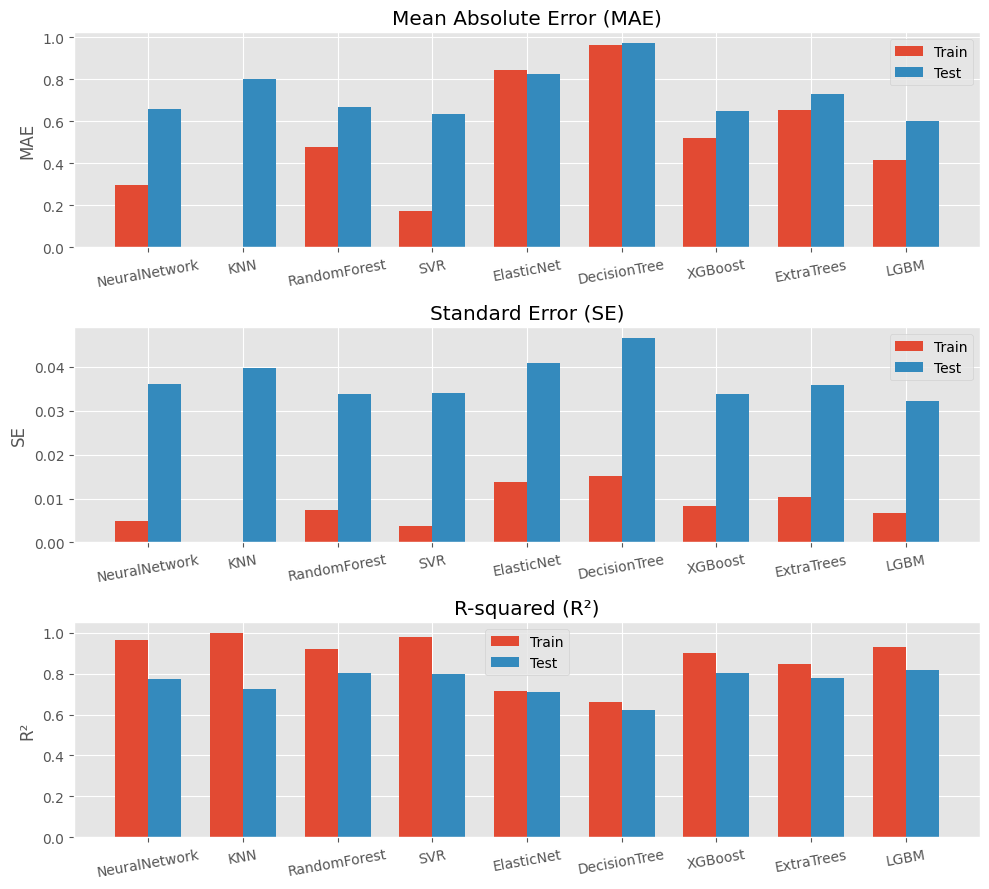

In [69]:
# Set up the subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
bar_width = 0.35
index = np.arange(len(model_dict))

# Define metrics for easier looping
metrics = ['MAE', 'SE', 'R²']
titles = ['Mean Absolute Error (MAE)', 'Standard Error (SE)', 'R-squared (R²)']

# Loop over each metric and corresponding axes
for i, metric in enumerate(metrics):
    # Plot the Train and Test metrics
    axs[i].bar(index, models.loc[f'Train ({metric})'], bar_width, label='Train')
    axs[i].bar(index + bar_width, models.loc[f'Test ({metric})'], bar_width, label='Test')

    # Set the x-axis labels and ticks
    axs[i].set_xticks(index + bar_width / 2)
    axs[i].set_xticklabels([model_info['name'] for model_info in model_dict.values()], rotation=10)
    axs[i].set_ylabel(metric)
    axs[i].set_title(titles[i])
    axs[i].legend(loc='best')

# Adjust layout
plt.tight_layout()
plt.show()

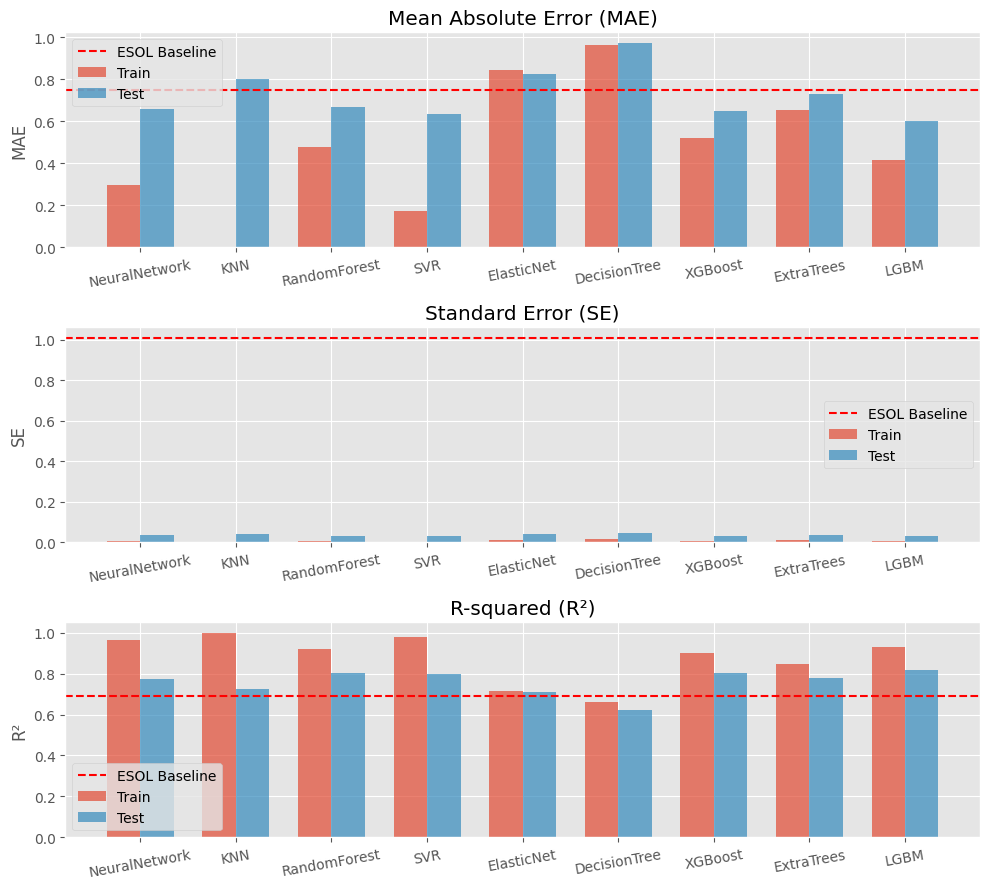

In [72]:
# Baseline values for ESOL
esol_baseline = {'R²': 0.69, 'SE': 1.01, 'MAE': 0.75}

# Set up the subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
bar_width = 0.35
index = np.arange(len(model_dict))

# Define metrics for easier looping
metrics = ['MAE', 'SE', 'R²']
titles = ['Mean Absolute Error (MAE)', 'Standard Error (SE)', 'R-squared (R²)']

# Loop over each metric and corresponding axes
for i, metric in enumerate(metrics):
    # Plot the Train and Test metrics
    axs[i].bar(index, models.loc[f'Train ({metric})'], bar_width, label='Train', alpha=0.7)
    axs[i].bar(index + bar_width, models.loc[f'Test ({metric})'], bar_width, label='Test', alpha=0.7)

    # Add a horizontal line for the ESOL baseline
    axs[i].axhline(y=esol_baseline[metric], color='red', linestyle='--', label='ESOL Baseline')

    # Set the x-axis labels and ticks
    axs[i].set_xticks(index + bar_width / 2)
    axs[i].set_xticklabels([model_info['name'] for model_info in model_dict.values()], rotation=10)
    axs[i].set_ylabel(metric)
    axs[i].set_title(titles[i])
    axs[i].legend(loc='best')

# Adjust layout
plt.tight_layout()
plt.show()

`Visualisasi` untuk memudahkan perbandingan masing-masing performa model.

## 8.2. Komparasi Prediktif vs Aktual

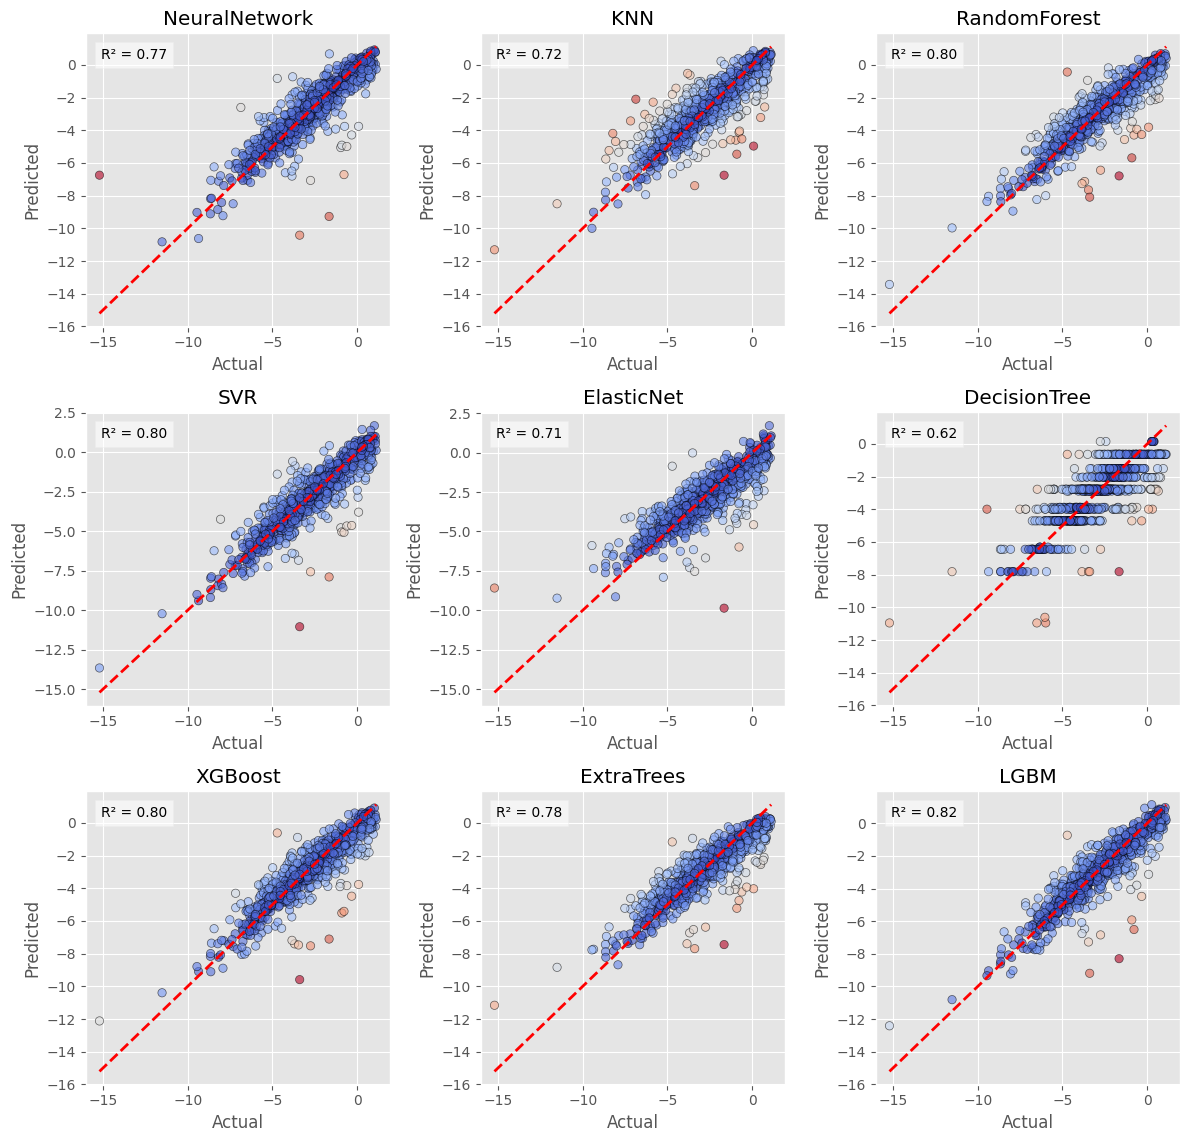

In [73]:
# Set up the figure for scatter plots
plt.figure(figsize=(12, 12))
num_rows, num_cols = 3, 3  # Assuming a 3x3 grid for up to 9 models
cmap = cm.coolwarm
norm = Normalize(vmin=y_test.min(), vmax=y_test.max())  # Normalize color range

# Iterate through models in model_dict
for i, (model_key, model_info) in enumerate(model_dict.items(), start=1):
    y_test_pred = model_info['predictions']['test']  # Use test predictions from model_dict

    # Create subplot
    plt.subplot(num_rows, num_cols, i)
    sc = plt.scatter(
        y_test,
        y_test_pred,
        c=np.abs(y_test_pred - y_test),
        cmap=cmap,
        edgecolor='k',
        alpha=0.6
    )
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line

    # Calculate and display R² score
    r2 = r2_score(y_test, y_test_pred)
    plt.text(
        0.05, 0.95, f'R² = {r2:.2f}',
        ha='left', va='top',
        transform=plt.gca().transAxes,
        fontsize=10, bbox=dict(facecolor='white', alpha=0.6)
    )

    # Set titles and labels
    plt.title(model_info['name'])  # Use model name from model_dict
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Berdasarkan nilai **R²**, model seperti `RandomForest`, `SVR`, `XGBoost`, dan `LightGBM` menunjukkan performa yang sangat baik dalam memprediksi data, dengan nilai **R²** pada data uji mendekati atau di atas 0.79. **LightGBM** memiliki performa terbaik dengan nilai **R²** sebesar 0.813, diikuti oleh **XGBoost** (0.798) dan **RandomForest** (0.792). Model **NeuralNetwork** juga menunjukkan performa yang solid dengan nilai **R²** sebesar 0.774, mendekati model dengan performa terbaik.

Sebaliknya, model seperti **KNN** meskipun memiliki nilai **R²** yang cukup baik (0.708), menunjukkan indikasi **overfitting**. Hal ini terlihat dari nilai **MAE** pada data latih yang sempurna (0.0) namun lebih besar pada data uji (0.820), menunjukkan ketidakmampuan model untuk menangkap pola pada data yang belum terlihat sebelumnya. **DecisionTree** memiliki performa terendah di antara semua model, dengan nilai **R²** sebesar 0.616, dan pola prediksinya terlihat kurang fleksibel, seperti yang dapat dilihat pada grafik dengan banyak nilai prediksi konstan terhadap sumbu `y`.

Meskipun model seperti **ExtraTrees** memiliki performa cukup baik (nilai **R²** 0.769), model ini menunjukkan keterbatasan pada rentang prediksi tertentu, terutama pada nilai ekstrem. **ElasticNet** juga memiliki performa yang cukup baik dengan nilai **R²** sebesar 0.704, namun relatif lebih rendah dibandingkan model lain seperti **SVR** (0.791).

Performa **XGBoost** dan **LightGBM** sudah sangat baik, namun dengan tuning **hyperparameter** yang lebih optimal (seperti jumlah pohon, kedalaman maksimum, atau kecepatan pembelajaran), model ini dapat menunjukkan hasil yang lebih unggul, terutama pada dataset yang kompleks.

Secara keseluruhan, pola prediksi menunjukkan bahwa distribusi data dan parameter model memiliki dampak besar pada hasil akhir, dengan beberapa model lebih sensitif terhadap parameter tertentu dibandingkan yang lain.

## 8.3. Random Data Tester

Selain `Metrik (MAE, SE, R²)` dan `Prediktif vs Aktual`, dilakukan `10 Random Data Testing` dengan menyertakan `3 model` dengan prediksi yang paling mendekati nilai aktual.

In [75]:
# Sample 5 test rows
sample_test = X_test.sample(n=5).copy()

# Create a dictionary for predictions
pred_dict = {'True LogS': y_test.loc[sample_test.index].values}

# Loop through models in model_dict and get predictions
for model_key, model_info in model_dict.items():
    pred_dict[model_info['name']] = model_info['model'].predict(sample_test).round(3)

# Convert predictions to a DataFrame
pred_df = pd.DataFrame(pred_dict)
pred_df.index = sample_test.index  # Retain original sample indices for reference

# Define the number of closest models to track
num_closest = 3  # Number of closest models you want to list

# Initialize a dictionary to store the closest model information
closest_models = {f'Closest Model {i}': [] for i in range(1, num_closest + 1)}

# Loop through each sample and find the closest models
for idx in pred_df.index:
    # Calculate absolute differences from True LogS for each model
    diffs = abs(pred_df.loc[idx, 'True LogS'] - pred_df.loc[idx, pred_df.columns != 'True LogS'])
    # Get the top `num_closest` models with the smallest differences
    top_closest = diffs.nsmallest(num_closest).index.tolist()

    # Store each closest model in the respective row
    for i, model_name in enumerate(top_closest, start=1):
        closest_models[f'Closest Model {i}'].append(model_name)

# Add closest models as new columns in the DataFrame
for i in range(1, num_closest + 1):
    pred_df[f'Closest Model {i}'] = closest_models[f'Closest Model {i}']

# Transpose for easier readability
pred_df.T

[LightGBM] [Warning] min_gain_to_split is set=0.07185890393911232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07185890393911232
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


,4823,66,6380,3674,4273
True LogS,-2.003185,-1.687449,-1.944657,-2.490308,-3.41
NeuralNetwork,-3.575,-2.375,-2.675,-2.825,-1.953
KNN,-2.235,-2.517,-2.301,-3.093,-2.13
RandomForest,-2.87,-2.713,-2.733,-2.553,-2.925
SVR,-3.091,-2.32,-2.413,-2.769,-1.983
ElasticNet,-3.322,-2.368,-3.36,-3.19,-2.947
DecisionTree,-3.992,-2.886,-2.774,-3.882,-2.774
XGBoost,-2.689,-2.785,-2.787,-2.593,-3.011
ExtraTrees,-2.917,-2.539,-2.763,-2.812,-2.732
LGBM,-2.472,-2.774,-2.611,-2.686,-2.708


Terlihat beberapa model `terbaik` seperti `RandomForest`, `SVR`, `XGBoost`, dan `LightGBM` lebih sering dinobatkan menjadi `Top 3`

## 8.4. Feature Importance (SHAP)

Pada tahap ini dilakukan pengukuran `Feature Importance` menggunakan `SHAP` pada `3 Model` terbaik berdasarkan nilai `R²`

In [83]:
# Baseline metrics for ESOL
esol_baseline = {'R²': 0.69, 'MAE': 0.75, 'SE': 1.01}

# Calculate R², MAE, and SE scores for each model
model_metrics = {
    model_info['name']: {
        'R²': models.loc['Test (R²)', model_key],
        'SE': models.loc['Test (SE)', model_key],
        'MAE': models.loc['Test (MAE)', model_key]
    }
    for model_key, model_info in model_dict.items()
}

# Filter models that perform better than ESOL
better_than_esol = {
    model_name: metrics
    for model_name, metrics in model_metrics.items()
    if metrics['R²'] > esol_baseline['R²']
    and metrics['SE'] < esol_baseline['SE']
    and metrics['MAE'] < esol_baseline['MAE']
}

# Sort the filtered models by R² (descending)
sorted_better_models = sorted(better_than_esol.items(), key=lambda x: x[1]['R²'], reverse=True)

# Display the models that perform better than ESOL
print("Models better than ESOL:")
for name, metrics in sorted_better_models:
    print(f"{name}: R² = {metrics['R²']:.2f}, SE = {metrics['SE']:.2f}, MAE = {metrics['MAE']:.2f}")

Models better than ESOL:
LGBM: R² = 0.82, SE = 0.03, MAE = 0.60
XGBoost: R² = 0.80, SE = 0.03, MAE = 0.65
RandomForest: R² = 0.80, SE = 0.03, MAE = 0.67
SVR: R² = 0.80, SE = 0.03, MAE = 0.63
ExtraTrees: R² = 0.78, SE = 0.04, MAE = 0.73
NeuralNetwork: R² = 0.77, SE = 0.04, MAE = 0.66


Calculating SHAP values for better models:   0%|          | 0/6 [00:00<?, ?it/s]

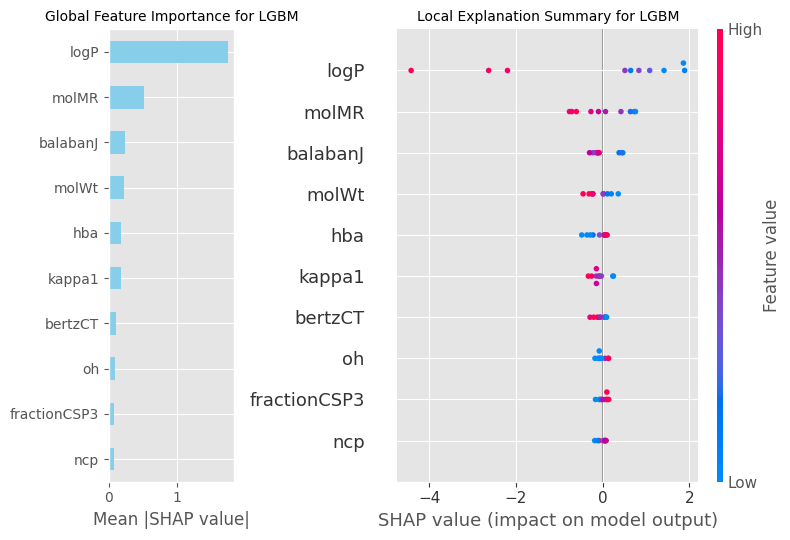

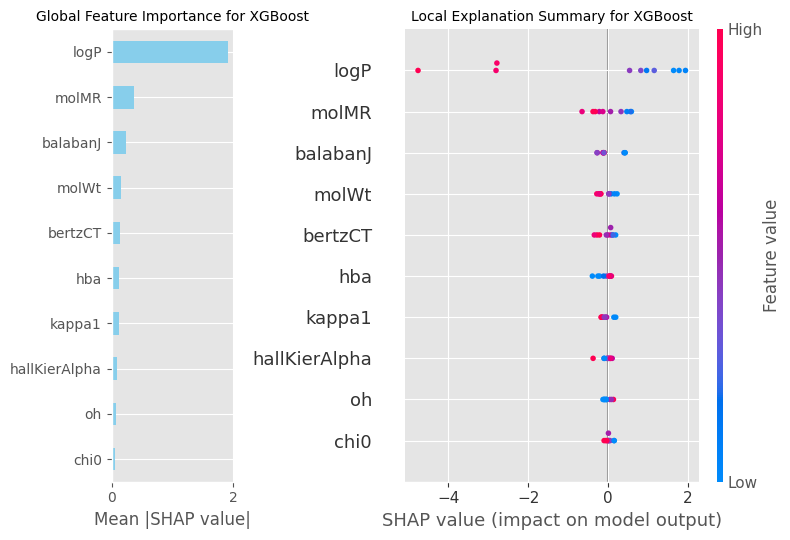

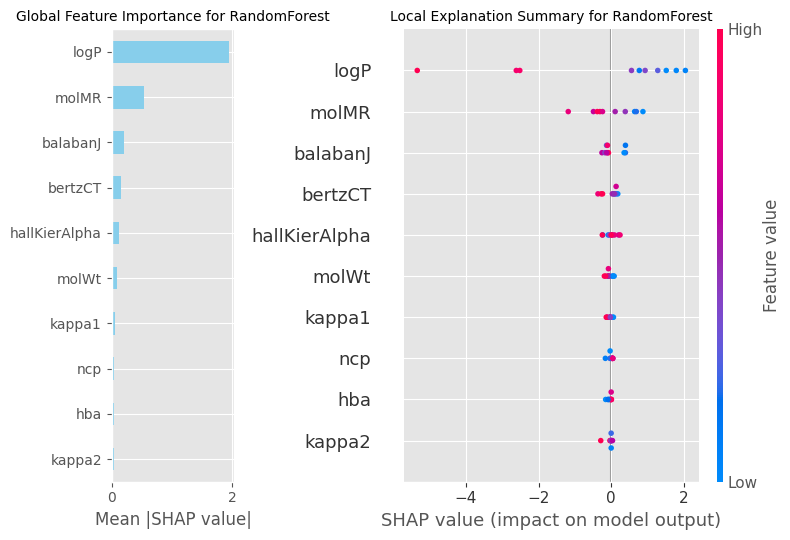

  0%|          | 0/10 [00:00<?, ?it/s]

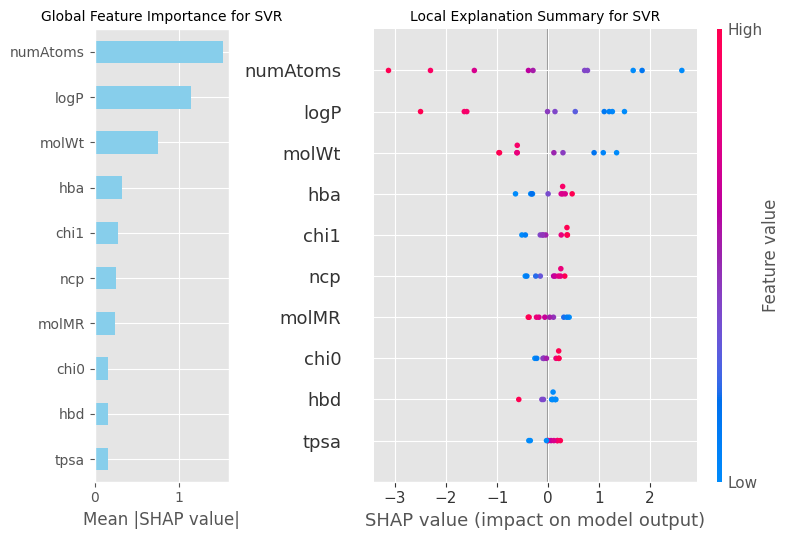

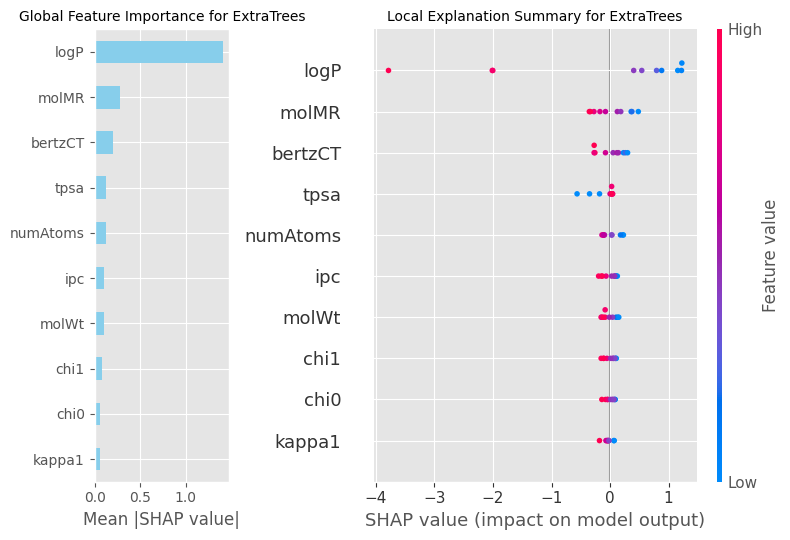

  0%|          | 0/10 [00:00<?, ?it/s]

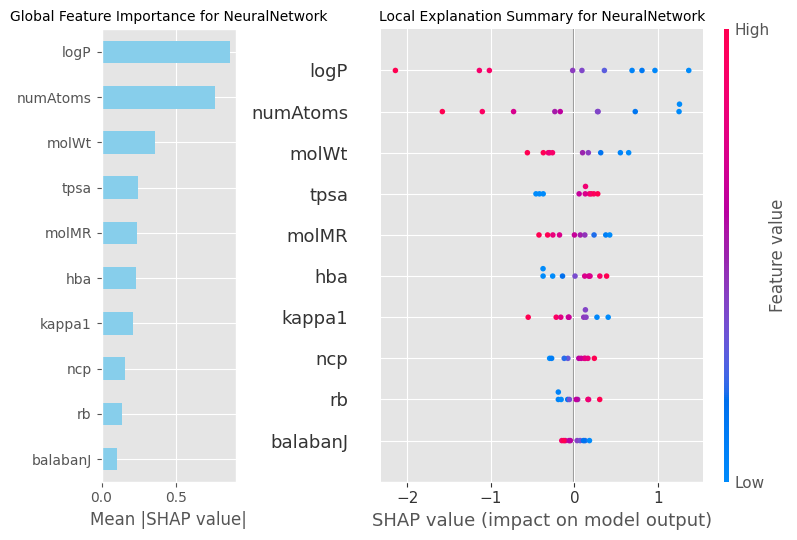

In [84]:
# Sample size for SHAP calculations (to speed up KernelExplainer)
shap_sample_size = 10  # Adjust this as needed to balance speed and accuracy

# Initialize dictionary to store SHAP values for faster access
shap_values_better = {}

# Reverse mapping of names to keys
name_to_key = {info['name']: key for key, info in model_dict.items()}

for model_name, metrics in tqdm(sorted_better_models, desc="Calculating SHAP values for better models"):
    model_key = name_to_key[model_name]
    model_info = model_dict[model_key]
    model = model_info['model']

    # Sample the test set for SHAP calculations (only a subset of data)
    X_test_sampled = X_test.sample(n=shap_sample_size, random_state=42)  # Ensure reproducibility with random_state

    # Initialize SHAP explainer
    if model_name in ['RandomForest', 'DecisionTree', 'XGBoost', 'ExtraTrees', 'LGBM']:
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.KernelExplainer(model.predict, X_test_sampled)

    # Compute SHAP values on the sampled test set
    shap_values = explainer.shap_values(X_test_sampled)
    shap_values_better[model_name] = shap_values

    # Compute global feature importance (only on the sampled data)
    shap_abs_mean = np.abs(shap_values).mean(axis=0)
    feature_importances = pd.Series(shap_abs_mean, index=X_test.columns)
    top_features_importance = feature_importances.nlargest(top_features)

    # Plot global and local SHAP explanations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9), gridspec_kw={'width_ratios': [1, 3]})

    # Global Feature Importance (Bar Plot)
    top_features_importance.plot(kind="barh", ax=ax1, color="skyblue")
    ax1.set_title(f"Global Feature Importance for {model_name}", fontsize=10)
    ax1.set_xlabel("Mean |SHAP value|")
    ax1.invert_yaxis()  # Highest importance on top

    # Local Explanation Summary (Dot Plot)
    shap.summary_plot(shap_values, X_test_sampled, plot_type="dot", max_display=top_features, show=False)
    ax2.set_title(f"Local Explanation Summary for {model_name}", fontsize=10)

    plt.tight_layout()
    plt.show()


Visualisasi dari model terbaik (`LGBM`, `XGBoost`, dan `Random Forest`) menunjukkan bahwa logP adalah fitur paling berpengaruh dalam memprediksi `logS`. Hal ini sejalan dengan formula `logS` yang dikenal, seperti:



<p align="center">

  <img src="./images/logS_GSE_dark.png">

</p>



`logK` mencerminkan konstanta kesetimbangan yang terkait dengan kelarutan, dan `logP` (`hidrofobisitas`) adalah faktor utama. Senyawa yang lebih `hidrofobik`, dengan nilai `logP` yang lebih tinggi, umumnya memiliki kelarutan lebih rendah dalam air, yang menjelaskan mengapa `logP` sangat memengaruhi prediksi `logS`.



Fitur lain, seperti `molMR` (molar refractivity) dan `molWt` (berat molekul), juga relevan, seperti yang terlihat pada formula lain:



<p align="center">

  <img src="./images/logS_ESOL_dark.png">

</p>



Formula ini semakin menekankan hubungan invers antara `logP` dan kelarutan. Konsistensi pentingnya `logP` pada formula empiris dan model pembelajaran mesin menunjukkan perannya yang sentral dalam merefleksikan interaksi molekul dengan pelarut yang menentukan kelarutan.

# Underground

In [80]:
print('STOP')

STOP
